# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> CS109A Introduction to Data Science: 

## Milestone 3: Trump Twitter Project 


**Harvard University**<br/>
**Fall 2019**<br/>
**Group 30**: Manish Babel, Narsing Rao Dyavani and Brian Hall

<hr style="height:2pt">


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import gridspec
import statsmodels.api as sm
from statsmodels.api import OLS
import time
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier  
from sklearn.model_selection import cross_val_score
from sklearn import preprocessing
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.linear_model import LassoCV

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn import metrics
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn import metrics
from pandas.plotting import scatter_matrix
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import losses


from tensorflow.keras import models
from tensorflow.keras import optimizers



import seaborn as sns

from datetime import datetime, date
from collections import Counter

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from gensim.models.ldamodel import LdaModel
from gensim.models import CoherenceModel
from gensim.corpora import Dictionary
from nltk.sentiment.vader import SentimentIntensityAnalyzer
%matplotlib inline

In [2]:
nltk.download('stopwords')
nltk.download('vader_lexicon')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/ndyavani/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/ndyavani/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

<B> I.  Loading the Twitter Data </B>

In the cells below, the Trump twitter data was loaded and previewed.  Additionally, a new "datetime" index was used to replace "created_at" to standardize the time.

In [3]:
#Load the data
df_TrumpTweets = pd.read_csv("data/Trump_Tweets.csv",header=0, encoding = 'unicode_escape')

# Convert created_at to datetime type
df_TrumpTweets['datetime'] = pd.to_datetime(df_TrumpTweets['created_at']) 

# Convert text to lowecase
df_TrumpTweets['text'] = df_TrumpTweets['text'].astype(str).str.lower()

# Review the data
print(df_TrumpTweets.shape)
print(df_TrumpTweets.head())

(13173, 7)
                                                text           created_at  \
0                            https://t.co/5tbgwkpv4p  11-17-2019 03:11:35   
1                            https://t.co/65erq7yfus  11-17-2019 02:23:27   
2                            https://t.co/yqjrgdpaoj  11-17-2019 02:22:20   
3  rt @realdonaldtrump: #newhoaxsameswamp https:/...  11-17-2019 01:06:30   
4  louisiana 3 hours left get out and vote for @e...  11-16-2019 23:22:52   

   retweet_count  favorite_count is_retweet               id_str  \
0          11274           36261      False  1195902274922569728   
1          12463           37866      False  1195890160006782976   
2          10891           33749      False  1195889880540336128   
3          33377               0       True  1195870796352278532   
4          13380           50435      False  1195844715238830082   

             datetime  
0 2019-11-17 03:11:35  
1 2019-11-17 02:23:27  
2 2019-11-17 02:22:20  
3 2019-11-17 01:06:30

In [4]:
def nltk_sentiment(sentence):
    from nltk.sentiment.vader import SentimentIntensityAnalyzer
    
    nltk_sentiment = SentimentIntensityAnalyzer()
    score = nltk_sentiment.polarity_scores(sentence)
    return score

In [5]:
nltk_results = [nltk_sentiment(row) for row in df_TrumpTweets['text']]
results_df = pd.DataFrame(nltk_results)

In [6]:
results_df.head()

,neg,neu,pos,compound
0,0.000,1.000,0.0,0.0000
1,0.000,1.000,0.0,0.0000
2,0.000,1.000,0.0,0.0000
3,0.000,1.000,0.0,0.0000
4,0.142,0.858,0.0,-0.3595


In [7]:
df_TrumpTweets = df_TrumpTweets.join(results_df)
df_TrumpTweets.head()

,text,created_at,retweet_count,favorite_count,is_retweet,id_str,datetime,neg,neu,pos,compound
0,https://t.co/5tbgwkpv4p,11-17-2019 03:11:35,11274,36261,False,1195902274922569728,2019-11-17 03:11:35,0.000,1.000,0.0,0.0000
1,https://t.co/65erq7yfus,11-17-2019 02:23:27,12463,37866,False,1195890160006782976,2019-11-17 02:23:27,0.000,1.000,0.0,0.0000
2,https://t.co/yqjrgdpaoj,11-17-2019 02:22:20,10891,33749,False,1195889880540336128,2019-11-17 02:22:20,0.000,1.000,0.0,0.0000
3,rt @realdonaldtrump: #newhoaxsameswamp https:/...,11-17-2019 01:06:30,33377,0,True,1195870796352278532,2019-11-17 01:06:30,0.000,1.000,0.0,0.0000
4,louisiana 3 hours left get out and vote for @e...,11-16-2019 23:22:52,13380,50435,False,1195844715238830082,2019-11-16 23:22:52,0.142,0.858,0.0,-0.3595


In [8]:
df_TrumpTweets.iloc[4]['text']

'louisiana 3 hours left get out and vote for @eddierispone for governor. lower taxes and much more!'

Below uses the tweet creation date to set index to datetime and drops "created_at" column since the datetime is now the panadas index.  Additionally, the twitter ID (id_str) is dropped as well as it will not be used for modeling (hard to see how the market will be impacted by the ID number of the tweet).

In [9]:
# Setting the index to Timestamp
df_TrumpTweets = df_TrumpTweets.set_index('datetime')

# Removing the tweet_id and create_at
df_TrumpTweets = df_TrumpTweets.drop(columns=['created_at', 'id_str'])

In [10]:
df_TrumpTweets.head()

,text,retweet_count,favorite_count,is_retweet,neg,neu,pos,compound
datetime,,,,,,,,
2019-11-17 03:11:35,https://t.co/5tbgwkpv4p,11274,36261,False,0.000,1.000,0.0,0.0000
2019-11-17 02:23:27,https://t.co/65erq7yfus,12463,37866,False,0.000,1.000,0.0,0.0000
2019-11-17 02:22:20,https://t.co/yqjrgdpaoj,10891,33749,False,0.000,1.000,0.0,0.0000
2019-11-17 01:06:30,rt @realdonaldtrump: #newhoaxsameswamp https:/...,33377,0,True,0.000,1.000,0.0,0.0000
2019-11-16 23:22:52,louisiana 3 hours left get out and vote for @e...,13380,50435,False,0.142,0.858,0.0,-0.3595


<B> II.  Prepating the Trump Data for Grouping by Subject </B>

It's important to remove stop words from the feature space as these words can be distracting and/or non-informative.  The code this section and others below is at times based on 109B materials and other information on the web as this is beyond the subjects covered in 109A. 

In [11]:
# Initialize a list of lists 
wordlist_of_list = []
# Initialize a single list
word_list = []
# Please note the code in this cell and other below wis based on 109B materials 
# As the subject is outside the scope of 109A materials
# Load stop words in english
stop_words = set(stopwords.words('english'))
# Update the stop words based on common words 
stop_words.update(['https','rt', 'co', 'amp', 'u', 'realdonaldtrump'])
# Tokenize 
for i in range(len(df_TrumpTweets)):
    words = []
    for j in RegexpTokenizer(r'[\w\']+').tokenize(df_TrumpTweets['text'][i]):
        if j not in stop_words:
            words.append(j)
            word_list.append(j)
    wordlist_of_list.append(words)

In [12]:
len(wordlist_of_list)

13173

It is interesting to see what the President says most commonly, but also to update the stop_words above to remove 'https','rt', 'co', 'amp', 'u' and 'realdonaldtrump'.

In [13]:
trump_wordcount_dict = Counter(word_list) 
trump_wordcount_dict.most_common(100)

[('great', 2503),
 ('president', 1415),
 ('people', 1285),
 ('trump', 1149),
 ('democrats', 979),
 ('thank', 937),
 ('country', 935),
 ('news', 897),
 ('big', 811),
 ('fake', 779),
 ('new', 763),
 ('get', 733),
 ('many', 729),
 ('today', 719),
 ('border', 710),
 ('america', 702),
 ('would', 672),
 ('time', 668),
 ('never', 627),
 ('media', 573),
 ('years', 572),
 ('american', 570),
 ('much', 569),
 ('one', 555),
 ('good', 549),
 ('want', 535),
 ('united', 508),
 ('states', 501),
 ('make', 500),
 ('even', 497),
 ('back', 488),
 ('vote', 480),
 ('must', 474),
 ('china', 459),
 ('done', 457),
 ('going', 453),
 ('house', 443),
 ('state', 432),
 ('like', 431),
 ('job', 430),
 ('jobs', 423),
 ('election', 414),
 ('us', 404),
 ('first', 401),
 ('dems', 399),
 ('bad', 390),
 ('day', 386),
 ('made', 384),
 ('military', 379),
 ('nothing', 371),
 ('ever', 364),
 ('whitehouse', 362),
 ('deal', 358),
 ('trade', 358),
 ('way', 356),
 ('win', 354),
 ('wall', 352),
 ('crime', 342),
 ('see', 341),
 ('s

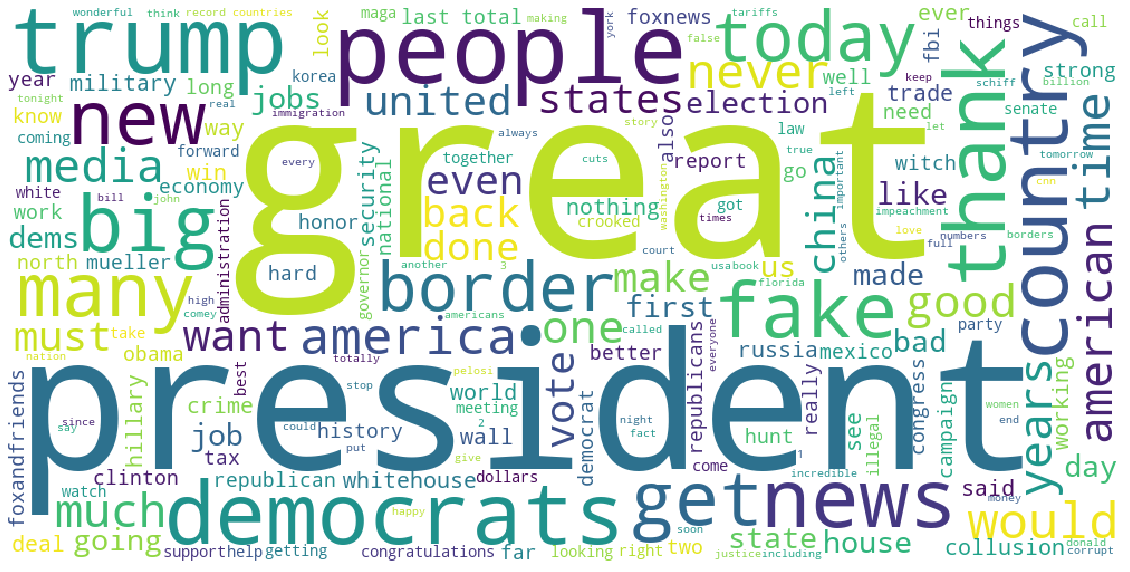

In [14]:
# Word cloud of the same from above
from wordcloud import WordCloud
trump_wordcloud = WordCloud(width = 1000, height = 500, background_color="white").generate_from_frequencies(trump_wordcount_dict)

plt.figure(figsize=(20,20))
plt.imshow(trump_wordcloud)
plt.axis("off")
plt.savefig('TrumpWordCloud.png', bbox_inches='tight')
plt.show()
plt.close()

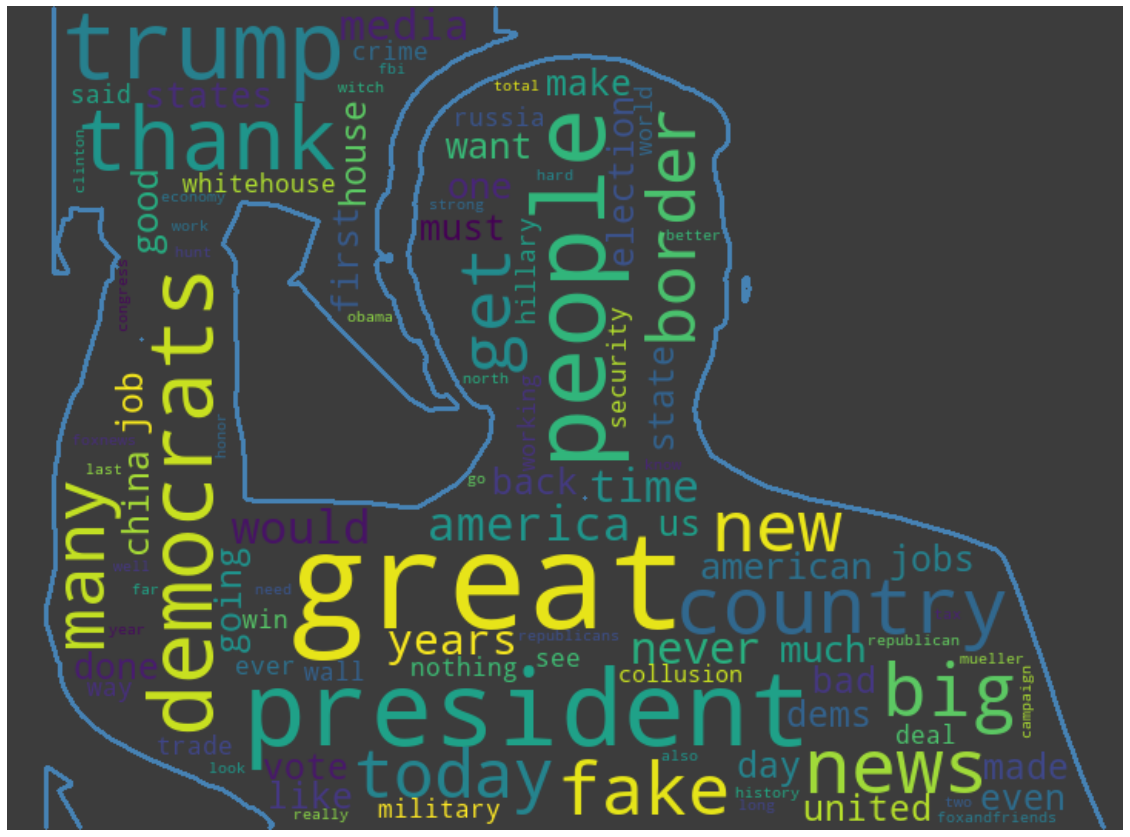

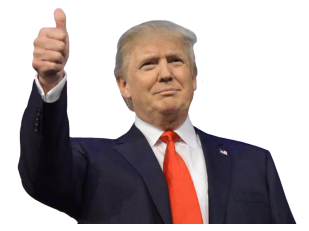

In [15]:
# This whole code is copied from 
# https://github.com/amueller/word_cloud/blob/master/examples/masked.py
# TO get pics for the website
# Please dont review this cell


from os import path
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os

from wordcloud import WordCloud, STOPWORDS

# get data directory (using getcwd() is needed to support running example in generated IPython notebook)
d = path.dirname(__file__) if "__file__" in locals() else os.getcwd()

# Read the whole text.
text = open(path.join(d, 'wiki_rainbow.txt')).read()
# print(text)
# read the mask image
# taken from
# http://www.stencilry.org/stencils/movies/alice%20in%20wonderland/255fk.jpg
alice_mask = np.array(Image.open(path.join(d, "donald_trump_PNG43.png")))

stopwords = set(STOPWORDS)
stopwords.add("said")

wc = WordCloud(#background_color="white", 
               background_color="#3C3C3C", 
               max_words=100, 
               mask=alice_mask,
               stopwords=stopwords, 
               contour_width=3, 
               contour_color='steelblue')

# generate word cloud
wc.generate_from_frequencies(trump_wordcount_dict)

# store to file
wc.to_file(path.join(d, "TrumpWordCloud_Face.png"))

# show
plt.figure(figsize=(20,30))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.figure()
plt.imshow(alice_mask, cmap=plt.cm.gray, interpolation='bilinear')
plt.axis("off")
plt.savefig('TrumpWordCloud_Face.png', bbox_inches='tight')
plt.show()

<B> III.  Selecting the Number of Groups for Trump Tweets</B>

Below, LdaModel is used to assign the Trump tweets to subject-based groups, and measuring the coherence of using such grouping.  Grouping the tweets from 1 to 9 groups was tested.

In [16]:
trump_dict = Dictionary(wordlist_of_list)
#corpus = [newdict.doc2bow(text) for text in wordlist_of_list]
corpus = list(map(trump_dict.doc2bow, wordlist_of_list))

In [17]:
def build_choerance(n):
    lda_model = LdaModel(corpus, num_topics=n, id2word=trump_dict, passes=15, random_state=2020)
    coherence_model = CoherenceModel(model=lda_model, corpus=corpus, dictionary=trump_dict, coherence='u_mass')
    coherence_value = coherence_model.get_coherence()
    print(n,coherence_value) 
    return coherence_value

c_values = list(map(build_choerance, range(1,10)))

1 -2.855535133003484
2 -3.3223425525696544
3 -3.56491231878749
4 -3.5944384571549244
5 -3.463415879812358
6 -3.798208759822961
7 -4.10429584891222
8 -3.806106382404775
9 -3.9666826206746597


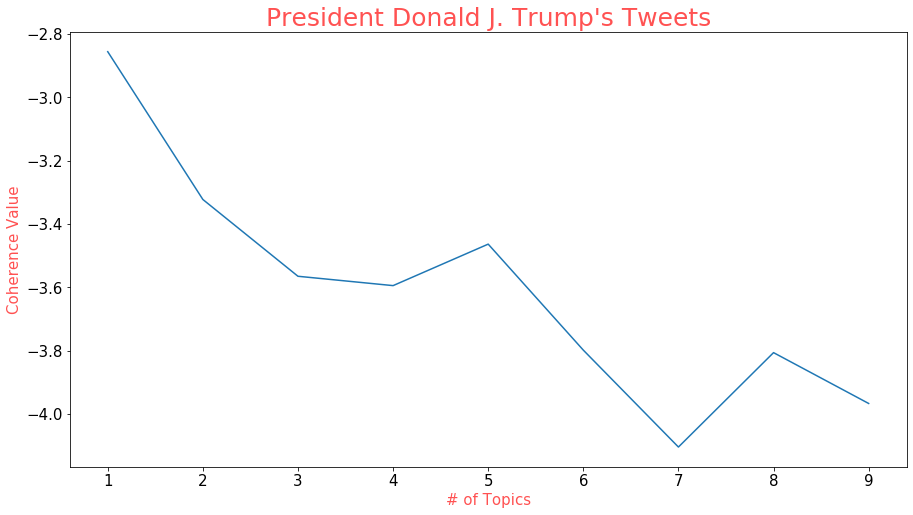

In [18]:
plt.figure(figsize=(15,8))
plt.plot(range(1,10),c_values)
plt.xlabel("# of Topics", fontsize=15, color="#FF5252")
plt.ylabel("Coherence Value", fontsize=15, color="#FF5252")
plt.title("President Donald J. Trump's Tweets", fontsize=25, color = "#FF5252")
plt.tick_params(labelsize=15)
plt.savefig('CoherenceValue.png', bbox_inches='tight')
plt.show()

Based on the above, let's go with 5 topics, after that, it seems to drop off in coherence value.

In [19]:
lda_model_5 = LdaModel(corpus, num_topics = 5, id2word = trump_dict, passes=15, random_state=2020)

In [20]:
df_word_beta = list(map(lambda n : pd.DataFrame(lda_model_5.show_topic(n, topn=10), columns=["word", "beta"]), 
                      range(5)))

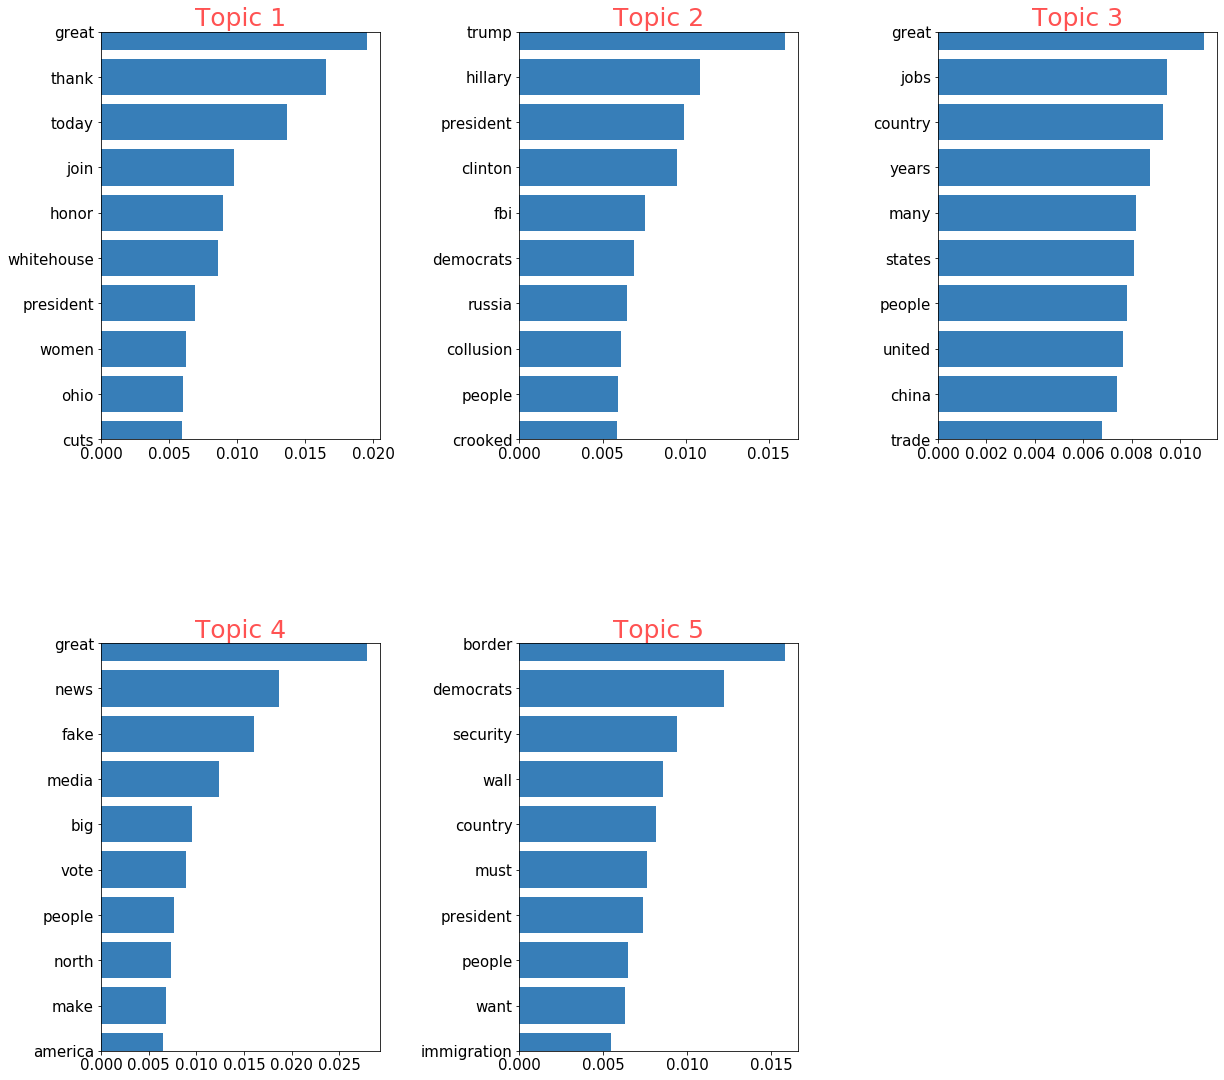

In [21]:
gs  = gridspec.GridSpec(3,3)
gs.update(wspace=0.5, hspace=0.5)
plt.figure(figsize=(20,30))
for i in range(len(df_word_beta)):
    ax = plt.subplot(gs[i])
    plt.barh(df_word_beta[i].index, df_word_beta[i]['beta'], align='center', color='#377eb8')
    ax.invert_yaxis()
    ax.set_yticks(df_word_beta[i].index)
    ax.set_yticklabels(df_word_beta[i]['word'])
    ax.tick_params(labelsize=15)
    plt.title("Topic "+str(i+1), fontsize=25, color = "#FF5252")

plt.savefig('TopWordByTopic.png', bbox_inches='tight')
plt.show()

Above are the top ten words found in each topical group.  

<B> IV.  Assigning the Trump Tweets to Groups</B>

With the number of groups selected as five, below each tweet was then assigned a group based on the most dominant subject of the text and stored in a new "Dominant_Topic" column.

In [22]:
# Given this material was not covered in 109A, online sources were used as resources
# This code is from https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/

def format_topics_sentences(ldamodel=lda_model_5, corpus=corpus, texts=wordlist_of_list):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model_5, corpus=corpus, texts=wordlist_of_list)

df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['DF_Row_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

df_dominant_topic.head()

,DF_Row_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,1.0,0.5886,"trump, hillary, president, clinton, fbi, democ...",[5tbgwkpv4p]
1,1,2.0,0.5873,"great, jobs, country, years, many, states, peo...",[65erq7yfus]
2,2,4.0,0.5907,"border, democrats, security, wall, country, mu...",[yqjrgdpaoj]
3,3,3.0,0.7307,"great, news, fake, media, big, vote, people, n...","[newhoaxsameswamp, gig9r9txe0]"
4,4,3.0,0.7164,"great, news, fake, media, big, vote, people, n...","[louisiana, 3, hours, left, get, vote, eddieri..."


In [23]:
df_copy = df_TrumpTweets.copy()
df_dominant = df_dominant_topic.copy()

df_dominant

,DF_Row_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,1.0,0.5886,"trump, hillary, president, clinton, fbi, democ...",[5tbgwkpv4p]
1,1,2.0,0.5873,"great, jobs, country, years, many, states, peo...",[65erq7yfus]
2,2,4.0,0.5907,"border, democrats, security, wall, country, mu...",[yqjrgdpaoj]
3,3,3.0,0.7307,"great, news, fake, media, big, vote, people, n...","[newhoaxsameswamp, gig9r9txe0]"
4,4,3.0,0.7164,"great, news, fake, media, big, vote, people, n...","[louisiana, 3, hours, left, get, vote, eddieri..."
...,...,...,...,...,...
13168,13168,1.0,0.5009,"trump, hillary, president, clinton, fbi, democ...","[atensnut, hillary, calls, trump's, remarks, h..."
13169,13169,2.0,0.6114,"great, jobs, country, years, many, states, peo...","[atensnut, many, times, must, said, actions, s..."
13170,13170,3.0,0.5101,"great, news, fake, media, big, vote, people, n...","[media, establishment, want, race, badly, neve..."
13171,13171,3.0,0.4573,"great, news, fake, media, big, vote, people, n...","[certainly, interesting, 24, hours]"


Below pd.concat is used to assign each trump text to its group (its dominant topic).

In [24]:
df_copy = df_TrumpTweets.copy()
#df_copy = df_copy.set_index(df_TrumpTweets['datetime'])
df_dominant = df_dominant_topic.copy()

# Set index to datetime before combining, drop unneeded rows
df_dom1 = df_dominant.set_index(df_TrumpTweets.index)
df_dom = df_dom1.drop(columns=['DF_Row_No', 'Text'])

# Assign each trump tweet to a dominant topic
result = pd.concat([df_copy, df_dom], axis=1, join='inner').reindex(df_copy.index)
print(result.shape)
# Select columns of interest
df = result[["Dominant_Topic", "text","neg","neu","pos","compound"]]
df.head()

(13173, 11)


,Dominant_Topic,text,neg,neu,pos,compound
datetime,,,,,,
2019-11-17 03:11:35,1.0,https://t.co/5tbgwkpv4p,0.000,1.000,0.0,0.0000
2019-11-17 02:23:27,2.0,https://t.co/65erq7yfus,0.000,1.000,0.0,0.0000
2019-11-17 02:22:20,4.0,https://t.co/yqjrgdpaoj,0.000,1.000,0.0,0.0000
2019-11-17 01:06:30,3.0,rt @realdonaldtrump: #newhoaxsameswamp https:/...,0.000,1.000,0.0,0.0000
2019-11-16 23:22:52,3.0,louisiana 3 hours left get out and vote for @e...,0.142,0.858,0.0,-0.3595


<B> V.  Preparing the Bitcoin Data</B>

Below the bitcoin data was loaded and used to create a Pandas dataframe. In the source dataset, the bitcoin pricing data was blank of there was no change in pricing during that minute, so the last price was used to fill such observations. Additionally, the percentage of price change over the next hour was calculated for each observation and stored as 'Next_Hour_Percent_Change'.

In [25]:
#Load the data
df_bitcoin_raw = pd.read_csv("data/bitstampUSD_1-min_data_2012-01-01_to_2019-08-12.csv",header=0)

# Convert created_at to datetime type
df_bitcoin_raw['Timestamp']=(pd.to_datetime(df_bitcoin_raw['Timestamp'],unit='s')) 

df_bitcoin = df_bitcoin_raw.set_index('Timestamp')

# Filter starting election day
df_bitcoin = df_bitcoin.loc[date(year=2016,month=11,day=7):]

# If NaN use use previous value (last market price during minutes of no trading/pricing)
#df_bitcoin = df_bitcoin.fillna(method='ffill')
df_bitcoin = df_bitcoin.replace('\s+', np.nan).ffill()

# Column to use for price
df_bitcoin = df_bitcoin[['Close']]

# Calculate the price change over an hour
df_bitcoin['Next_Hour_Percent_Change'] = ((df_bitcoin['Close'] / df_bitcoin['Close'].shift(60) - 1) * 100)

# Move so shows the price change that will happen in the next hour. 
df_bitcoin.Next_Hour_Percent_Change = df_bitcoin.Next_Hour_Percent_Change.shift(-60)
df_bitcoin = df_bitcoin[['Next_Hour_Percent_Change']]

print(df_bitcoin.shape)
df_bitcoin = df_bitcoin.dropna()
df_bitcoin.head()
print(df_bitcoin.shape)
# df_bitcoin.isna().sum()



(1451521, 1)
(1451461, 1)


<B> VI.  Combining the Twitter and Bitcoin Data</B>

For each minute there was a Trump tweet in the time period at issue, a resulting percentage change in bitcoin price for the next hour from the bitcoin dataset was merged into the Trump tweet dataset.  

In [26]:
Trump_df = df

# Round seconds down to align with bitcoin timestamp (in order to later merge)
Trump_df.index = Trump_df.index.map(lambda x: x.replace(second=0))

# Filter to match maximum extentof bitcoin data (tweets only until 8/10/2019)
Trump_df1 = Trump_df.sort_values(by='datetime',ascending=True)
Trump_df2 = Trump_df1.loc[: date(year=2019,month=8,day=10)]

# Datetime index into separate column
df_bitcoin.index.names = ['datetime']
df_bitcoin1 = df_bitcoin.reset_index()
Trump_df3 = Trump_df2.reset_index()

# Merge on the datetime for each instance of a Trump tweet
df3 = pd.merge(Trump_df3, df_bitcoin1, on='datetime', how='inner')

# Check for missing price change values
print(sum(df3.Next_Hour_Percent_Change.isna()))

df_Trump = df3[['datetime', 'text', 'Dominant_Topic', 'Next_Hour_Percent_Change',"neg","neu","pos","compound"]]
df_Trump.isna().sum()
df_Trump 

0


,datetime,text,Dominant_Topic,Next_Hour_Percent_Change,neg,neu,pos,compound
0,2016-11-07 00:09:00,our american comeback story begins 11/8/16. to...,3.0,-0.567306,0.000,0.700,0.300,0.8070
1,2016-11-07 01:52:00,thank you michigan! this is a movement that wi...,3.0,0.358449,0.000,0.780,0.220,0.6229
2,2016-11-07 04:14:00,thank you pennsylvania- i am forever grateful ...,3.0,-0.121022,0.000,0.423,0.577,0.9468
3,2016-11-07 06:35:00,thank you for you support virginia! in one day...,0.0,0.042530,0.000,0.708,0.292,0.6988
4,2016-11-07 17:10:00,starting tomorrow it's going to be #americafir...,3.0,0.401218,0.000,0.661,0.339,0.8011
...,...,...,...,...,...,...,...,...
9800,2019-08-09 12:03:00,....mentally ill or deranged people. i am the ...,4.0,1.194348,0.040,0.714,0.246,0.8955
9801,2019-08-09 12:03:00,serious discussions are taking place between h...,3.0,1.194348,0.026,0.791,0.183,0.8384
9802,2019-08-09 18:44:00,....to inflame and cause chaos. they create th...,4.0,0.205653,0.407,0.481,0.112,-0.9311
9803,2019-08-09 18:44:00,liberal hollywood is racist at the highest lev...,1.0,0.205653,0.121,0.741,0.138,0.2509


<B> VII.  Visual Exploration of the Data:  Features and Outcome </B>

To ascertain the distribution in the grouping of the trump tweets, a histogram was prepared and reveals that the grouping is balanced.  Additionally, the distribution of the change in the bitcoin price at each observation was examined and appears to be roughly normally distributed with a near 0 mean, though there are long tails on each side.  It will be interesting to see the impact of the long tails (outliers) on the models. 

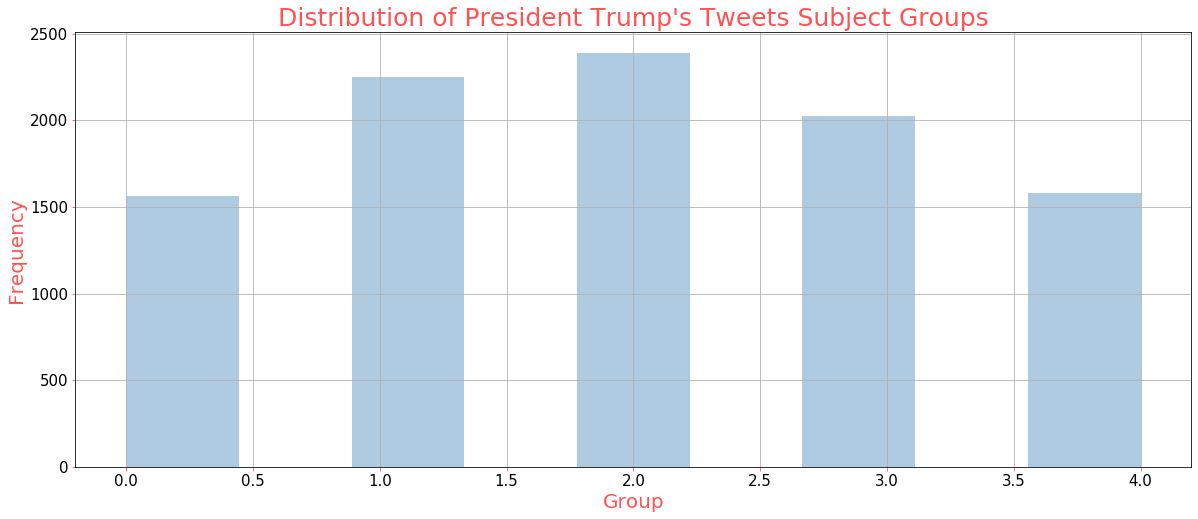

In [27]:
ax, fig = plt.subplots(figsize=(20,8))
ax = sns.distplot(df_Trump['Dominant_Topic'], kde=False, bins=9, color='#377eb8')
ax.set_title("Distribution of President Trump's Tweets Subject Groups", fontsize=25, color = "#FF5252")
ax.set_ylabel('Frequency', fontsize=20, color = "#FF5252")
ax.set_xlabel('Group', fontsize=20, color = "#FF5252")
ax.tick_params(labelsize=15, color = "#FF5252")
ax.grid(True)
plt.savefig('DistTrumpTweetsSubject.png', bbox_inches='tight')
plt.show()

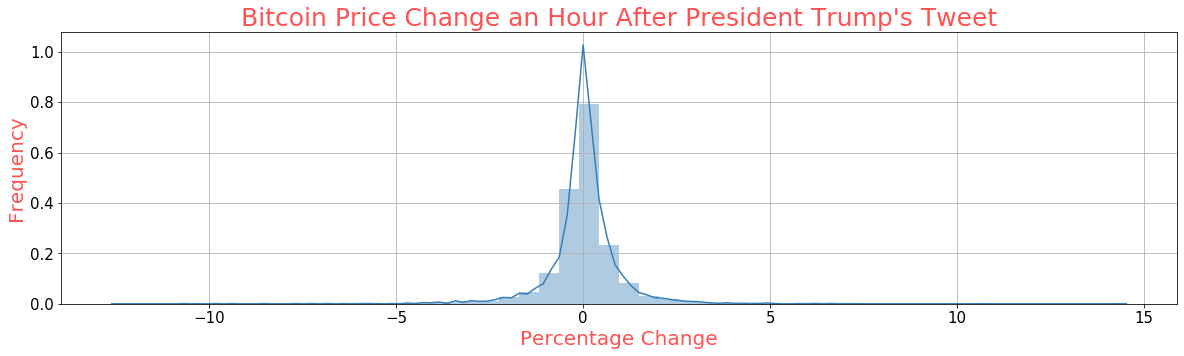

In [28]:
ax, fig = plt.subplots(figsize=(20,5))
ax = sns.distplot(df_Trump['Next_Hour_Percent_Change'], kde=True, color='#377eb8')
ax.set_title("Bitcoin Price Change an Hour After President Trump's Tweet",  fontsize=25, color = "#FF5252")
ax.set_ylabel('Frequency',  fontsize=20, color = "#FF5252")
ax.set_xlabel('Percentage Change',  fontsize=20, color = "#FF5252")
ax.tick_params(labelsize=15)
ax.grid(True)
plt.savefig('ChangeinBitcoinAfterTrumpTweet.png', bbox_inches='tight')
plt.show()

In [29]:
df_Trump['Next_Hour_Percent_Change'].describe()

count    9805.000000
mean        0.016607
std         0.985678
min       -12.374803
25%        -0.259727
50%         0.023665
75%         0.341791
max        14.298360
Name: Next_Hour_Percent_Change, dtype: float64

In [30]:
df_bitcoin.index

DatetimeIndex(['2016-11-07 00:00:00', '2016-11-07 00:01:00',
               '2016-11-07 00:02:00', '2016-11-07 00:03:00',
               '2016-11-07 00:04:00', '2016-11-07 00:05:00',
               '2016-11-07 00:06:00', '2016-11-07 00:07:00',
               '2016-11-07 00:08:00', '2016-11-07 00:09:00',
               ...
               '2019-08-11 22:51:00', '2019-08-11 22:52:00',
               '2019-08-11 22:53:00', '2019-08-11 22:54:00',
               '2019-08-11 22:55:00', '2019-08-11 22:56:00',
               '2019-08-11 22:57:00', '2019-08-11 22:58:00',
               '2019-08-11 22:59:00', '2019-08-11 23:00:00'],
              dtype='datetime64[ns]', name='datetime', length=1451461, freq=None)

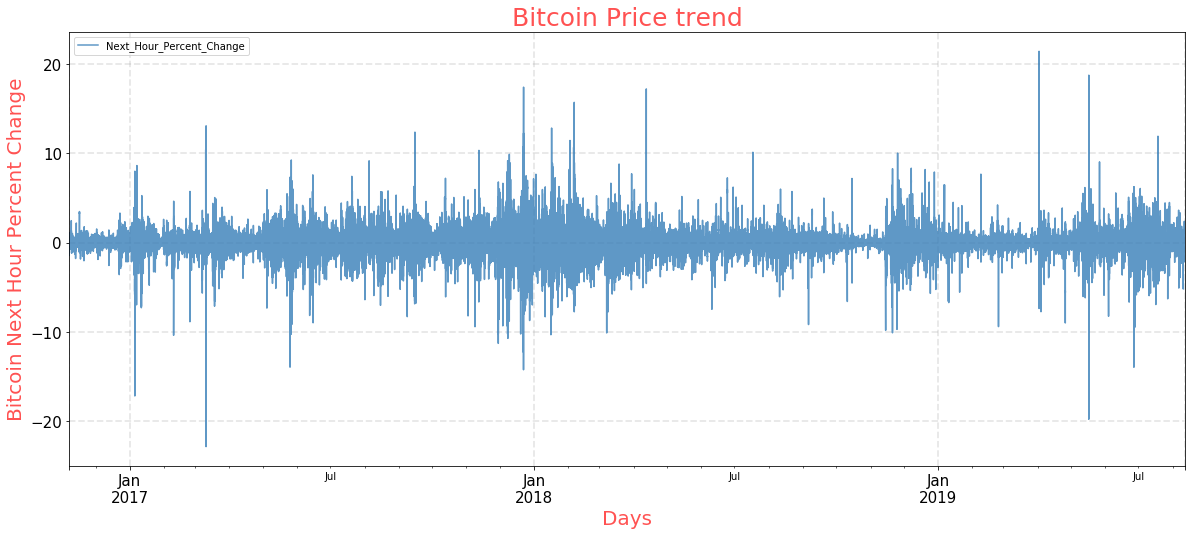

In [31]:
#  Trend of Bitcoin data
df_bitcoin_change = df_bitcoin.copy()

fig, ax = plt.subplots(figsize=(20,8))  
df_bitcoin_change.plot(ax=ax,alpha=0.8, color='#377eb8')
ax.set_xlabel("Days", fontsize=20, color = "#FF5252")
ax.set_ylabel("Bitcoin Next Hour Percent Change", fontsize=20, color = "#FF5252")
ax.set_title("Bitcoin Price trend", fontsize=25, color = "#FF5252")
ax.grid(True, lw=1.75, ls='--', alpha=0.30)
ax.tick_params(labelsize = 15)
plt.savefig('BitcoinPriceTrend.png', bbox_inches='tight')
plt.show()

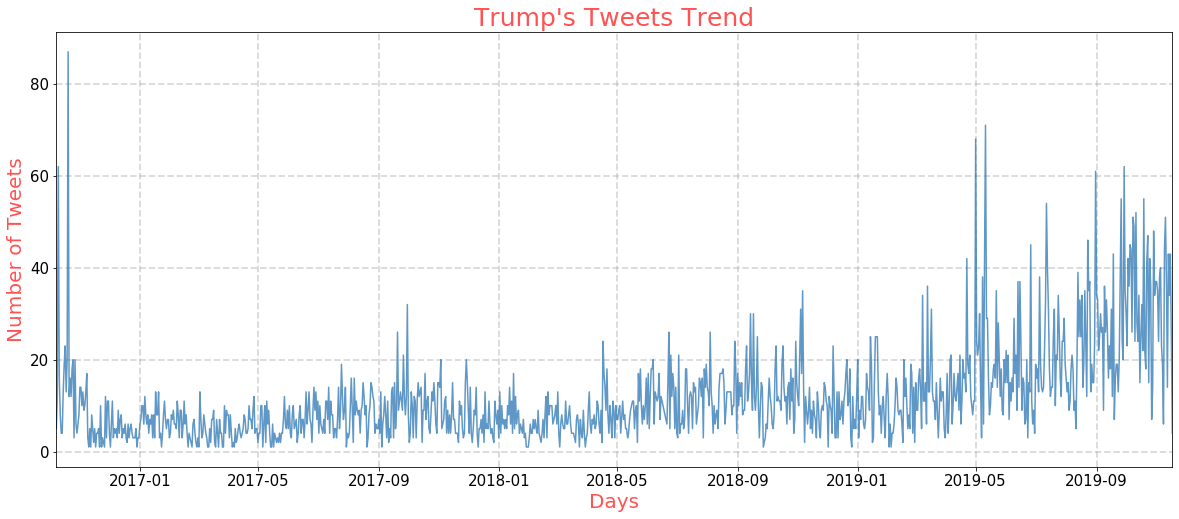

In [32]:
# Trumps Tweets trend
df_tweet_per_day = df.copy()
df_tweet_per_day['date'] = df_tweet_per_day.index.date
df_tweet_per_day=df_tweet_per_day.date.value_counts()

fig, ax = plt.subplots(figsize=(20,8))  
df_tweet_per_day.plot(ax=ax,alpha=0.8, color='#377eb8')
ax.set_xlabel("Days", fontsize=20, color = "#FF5252")
ax.set_ylabel("Number of Tweets", fontsize = 20, color = "#FF5252")
ax.set_title("Trump's Tweets Trend", fontsize=25, color = "#FF5252")
ax.grid(True, lw=1.75, ls='--', alpha=0.50)
ax.tick_params(labelsize = 15)
plt.savefig('TrunpTweetTrend.png', bbox_inches='tight')
plt.show()


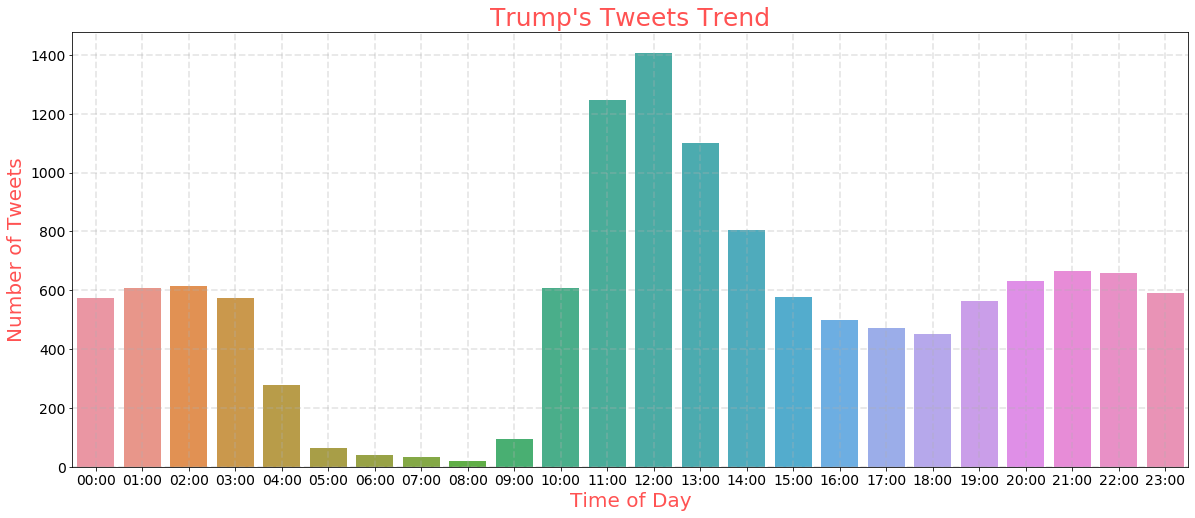

In [33]:
# Trump Tweet trend on hourly basis
df_tweet_per_hour = df.copy()
df_tweet_per_hour.index = df_tweet_per_hour.index.map(lambda x: x.replace(second=0))
df_tweet_per_hour = df_tweet_per_hour.sort_values(by='datetime',ascending=True)
df_tweet_per_hour['hour'] = df_tweet_per_hour.index.hour


def __fmt_timemin(minutes):
    hour, minutes_rem = divmod(int(minutes),1)
    return "{0:02d}:{1:02d}".format(int(hour),int(minutes_rem))
x_ticks = np.linspace(0, 23, 24)
x_ticks_labels = list(map(__fmt_timemin,x_ticks))


fig, ax = plt.subplots(figsize=(20,8)) 
sns.set_context("notebook", font_scale=1, rc={"lines.linewidth": 2.5})
ax = sns.countplot(x="hour", data=df_tweet_per_hour)
ax.set_xlabel("Time of Day", fontsize=20, color = "#FF5252")
ax.set_ylabel("Number of Tweets", fontsize=20, color = "#FF5252")
ax.set_title("Trump's Tweets Trend", fontsize=25, color = "#FF5252")
ax.grid(True, lw=1.75, ls='--', alpha=0.30)
plt.xticks(x_ticks,x_ticks_labels)
ax.tick_params(labelsize = 14)
plt.savefig('TrunpTweetTrendByTimeofDay.png', bbox_inches='tight')
plt.show()

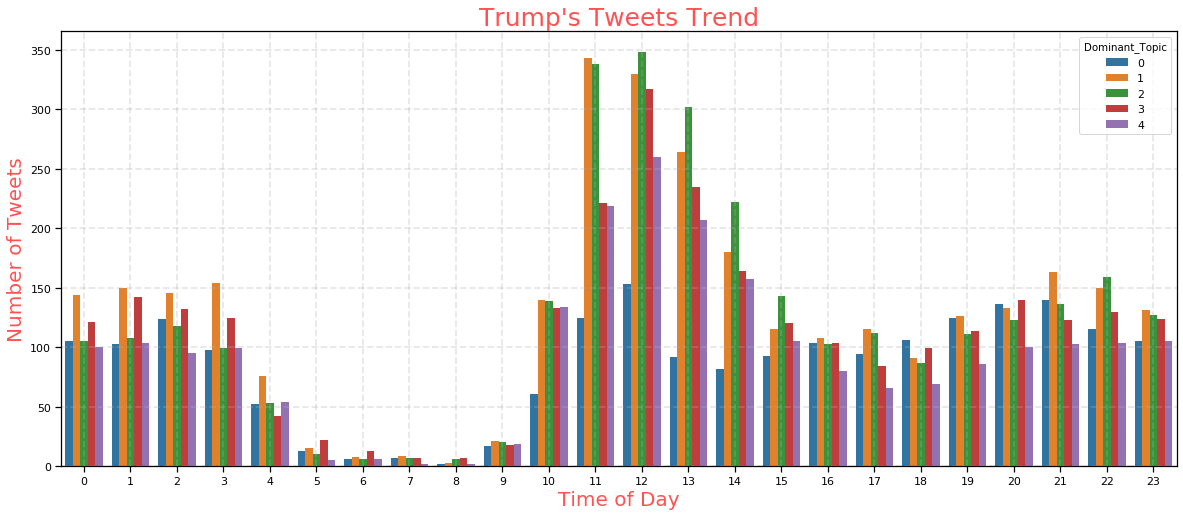

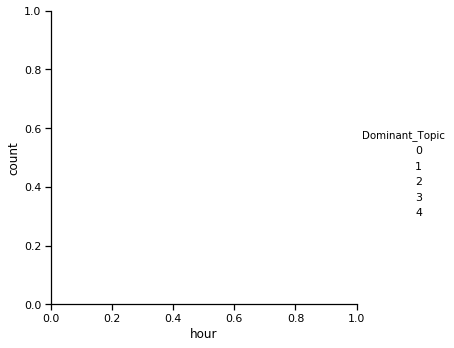

In [34]:
# Trump Tweet Trend on hourly basis grouped by topics
df_tweet_per_hour = df_tweet_per_hour.sort_values(by='hour',ascending=True)
df_tweet_per_hour['Dominant_Topic'] = df_tweet_per_hour['Dominant_Topic'].astype('int')


fig, ax = plt.subplots(figsize=(20,8))  
sns.set_context("notebook", font_scale=1, rc={"lines.linewidth": 2.5})
sns.catplot(data=df_tweet_per_hour,kind='count',x='hour',hue='Dominant_Topic',ax=ax)
ax.set_xlabel("Time of Day", fontsize=20, color = "#FF5252")
ax.set_ylabel("Number of Tweets", fontsize=20, color = "#FF5252")
ax.set_title("Trump's Tweets Trend", fontsize=25, color = "#FF5252")
ax.grid(True, lw=1.75, ls='--', alpha=0.30)
# plt.xticks(x_ticks,x_ticks_labels);
# ax.tick_params(labelsize = 12);
#fig.savefig('ax2_figure.png', bbox_inches=extent)

fig.savefig('TrunpTweetTrendByTopic.png', bbox_inches='tight')
plt.show()

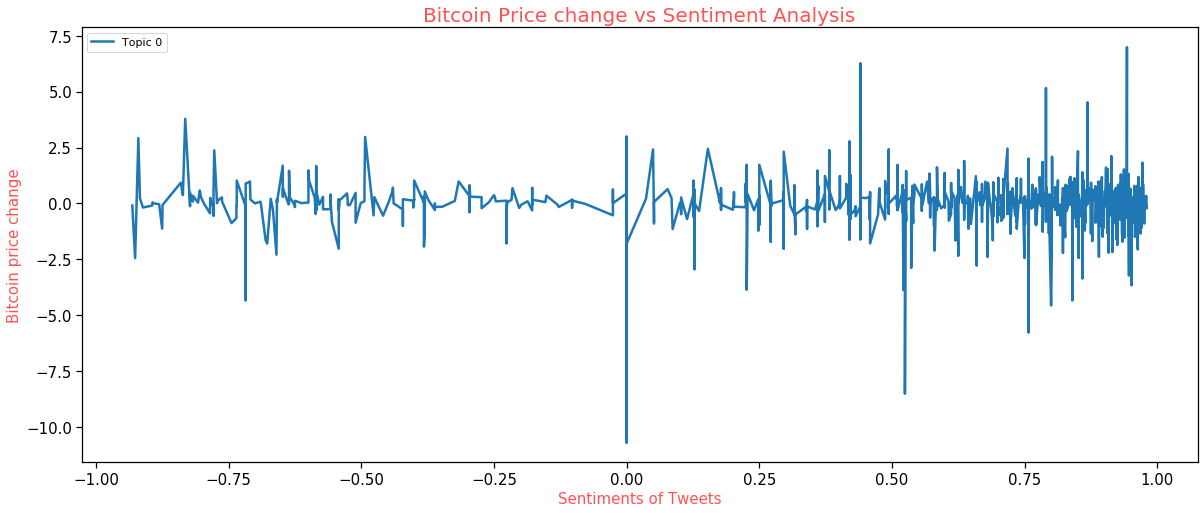

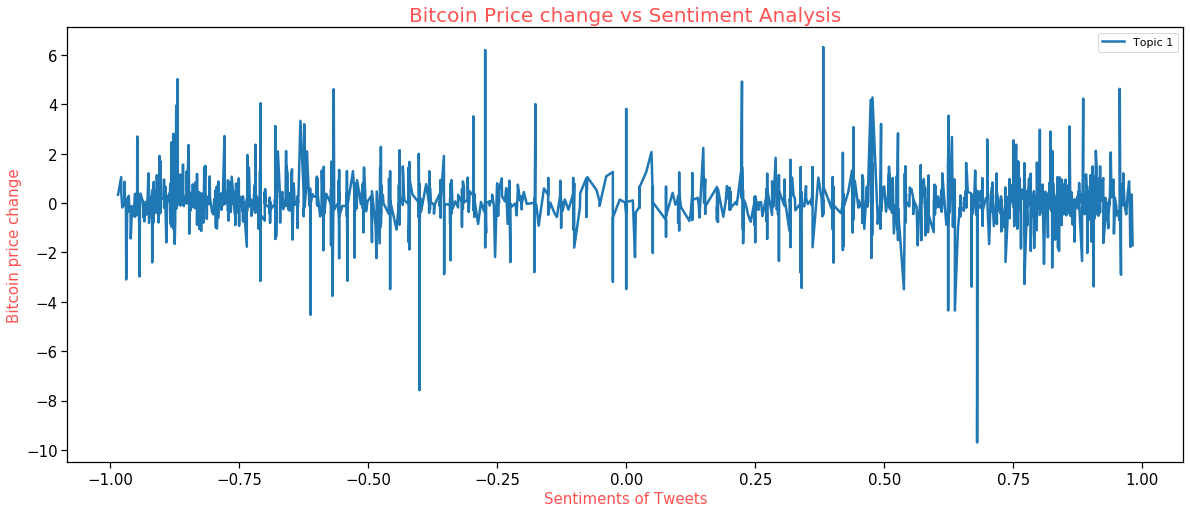

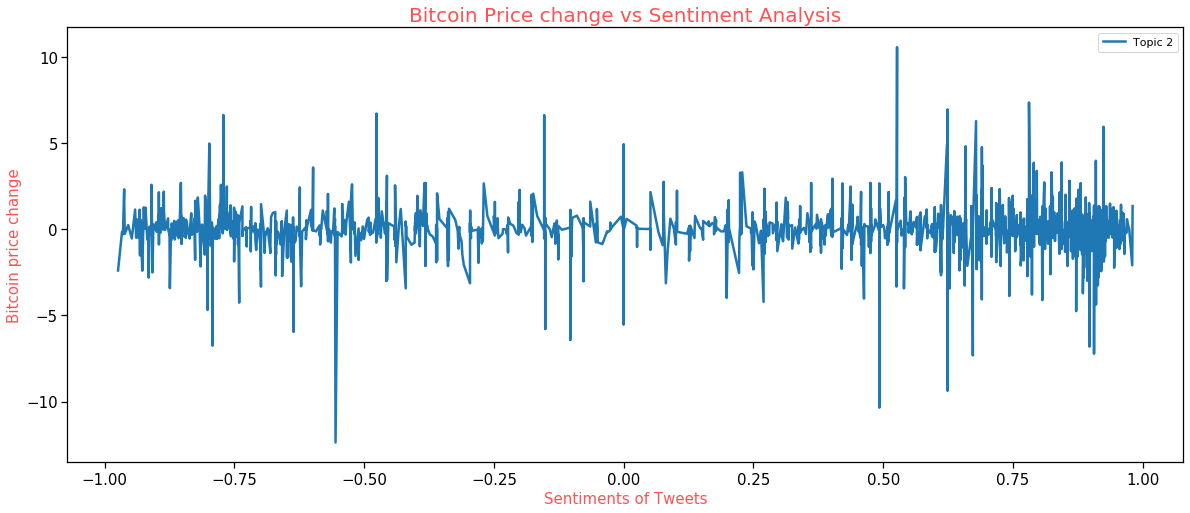

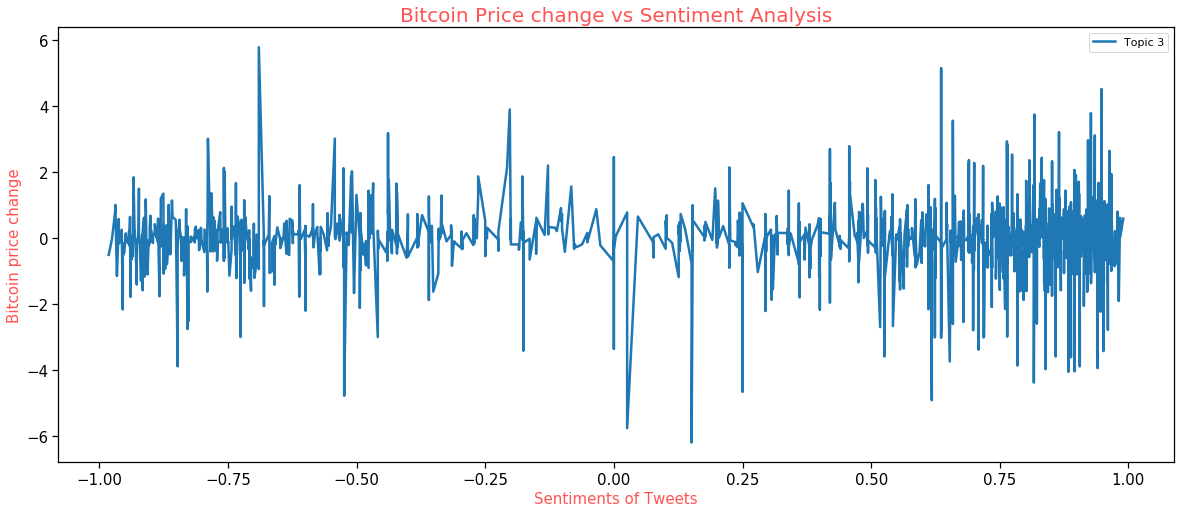

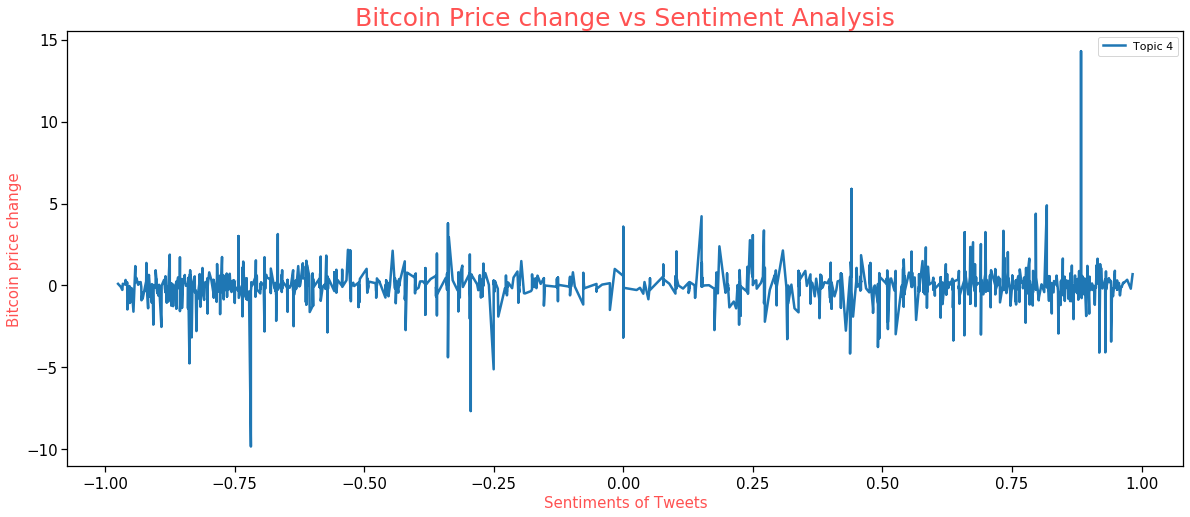

In [35]:
# Bitcoin Price change based on Sentiments of Trump Tweets

df_tweet_per_sentiment = df_Trump.copy()
df_tweet_per_sentiment_0 = df_tweet_per_sentiment[df_tweet_per_sentiment.Dominant_Topic == 0.0]
x_val = df_tweet_per_sentiment_0.sort_values(by='compound')['compound']
y_val = df_tweet_per_sentiment_0['Next_Hour_Percent_Change'].loc[x_val.index]
fig, ax = plt.subplots(1,1 ,figsize=(20,8))  
ax.plot(x_val,y_val, label="Topic 0");
ax.set_title('Bitcoin Price change vs Sentiment Analysis', fontSize=20, color = "#FF5252")
ax.set_xlabel('Sentiments of Tweets', fontSize=15, color = "#FF5252")
ax.set_ylabel('Bitcoin price change', fontSize=15, color = "#FF5252")
ax.tick_params(labelsize = 15);
ax.legend();
fig.savefig('Topic0.png', bbox_inches='tight')

df_tweet_per_sentiment_1 = df_tweet_per_sentiment[df_tweet_per_sentiment.Dominant_Topic == 1.0]
x_val = df_tweet_per_sentiment_1.sort_values(by='compound')['compound']
y_val = df_tweet_per_sentiment_1['Next_Hour_Percent_Change'].loc[x_val.index]
fig, ax = plt.subplots(1,1 ,figsize=(20,8))  
ax.plot(x_val,y_val, label="Topic 1");
ax.set_title('Bitcoin Price change vs Sentiment Analysis', fontSize=20, color = "#FF5252")
ax.set_xlabel('Sentiments of Tweets', fontSize=15, color = "#FF5252")
ax.set_ylabel('Bitcoin price change', fontSize=15, color = "#FF5252")
ax.tick_params(labelsize = 15);
ax.legend();
fig.savefig('Topic1.png', bbox_inches='tight')


df_tweet_per_sentiment_2 = df_tweet_per_sentiment[df_tweet_per_sentiment.Dominant_Topic == 2.0]
x_val = df_tweet_per_sentiment_2.sort_values(by='compound')['compound']
y_val = df_tweet_per_sentiment_2['Next_Hour_Percent_Change'].loc[x_val.index]
fig, ax = plt.subplots(1,1 ,figsize=(20,8))  
ax.plot(x_val,y_val, label="Topic 2");
ax.set_title('Bitcoin Price change vs Sentiment Analysis', fontSize=20, color = "#FF5252")
ax.set_xlabel('Sentiments of Tweets', fontSize=15, color = "#FF5252")
ax.set_ylabel('Bitcoin price change', fontSize=15, color = "#FF5252")
ax.tick_params(labelsize = 15);
ax.legend();
fig.savefig('Topic2.png', bbox_inches='tight')

df_tweet_per_sentiment_3 = df_tweet_per_sentiment[df_tweet_per_sentiment.Dominant_Topic == 3.0]
x_val = df_tweet_per_sentiment_3.sort_values(by='compound')['compound']
y_val = df_tweet_per_sentiment_3['Next_Hour_Percent_Change'].loc[x_val.index]
fig, ax = plt.subplots(1,1 ,figsize=(20,8))  
ax.plot(x_val,y_val, label="Topic 3");
ax.set_title('Bitcoin Price change vs Sentiment Analysis', fontSize=20, color = "#FF5252")
ax.set_xlabel('Sentiments of Tweets', fontSize=15, color = "#FF5252")
ax.set_ylabel('Bitcoin price change', fontSize=15, color = "#FF5252")
ax.tick_params(labelsize = 15);
ax.legend();
fig.savefig('Topic3.png', bbox_inches='tight')

df_tweet_per_sentiment_4 = df_tweet_per_sentiment[df_tweet_per_sentiment.Dominant_Topic == 4.0]
x_val = df_tweet_per_sentiment_4.sort_values(by='compound')['compound']
y_val = df_tweet_per_sentiment_4['Next_Hour_Percent_Change'].loc[x_val.index]

fig, ax = plt.subplots(1,1 ,figsize=(20,8))  
ax.plot(x_val,y_val, label="Topic 4");


ax.set_title('Bitcoin Price change vs Sentiment Analysis', fontSize=25, color = "#FF5252")
ax.set_xlabel('Sentiments of Tweets', fontSize=15, color = "#FF5252")
ax.set_ylabel('Bitcoin price change', fontSize=15, color = "#FF5252")
ax.tick_params(labelsize = 15);
ax.legend();
fig.savefig('Topic4.png', bbox_inches='tight')

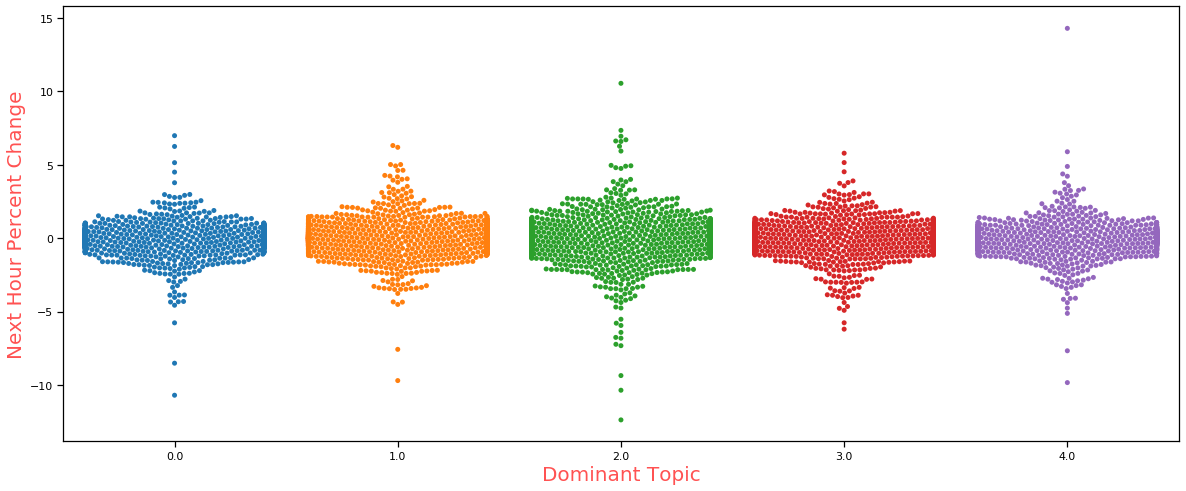

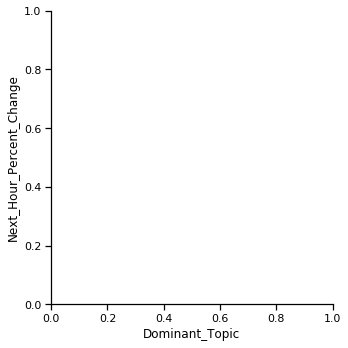

In [36]:
# Bitcoin Price change based on Sentiments of Trump Tweets
df_tweet_per_topic_1= df_Trump.copy()
df_tweet_per_topic_1
x_val = df_tweet_per_sentiment[df_tweet_per_sentiment['Dominant_Topic'] == 2.0]['Dominant_Topic']
y_val = df_tweet_per_sentiment['Next_Hour_Percent_Change'].loc[x_val.index]
fig, ax = plt.subplots(figsize=(20,8))  
sns.catplot(x="Dominant_Topic", y="Next_Hour_Percent_Change", kind="swarm",
            data=df_tweet_per_sentiment, ax=ax)
ax.set_xlabel("Dominant Topic", fontsize=20, color = "#FF5252");
ax.set_ylabel("Next Hour Percent Change", fontsize=20, color = "#FF5252");
# ax.set_title("Trump's Tweets Trend", fontsize=25, color = "#FF5252")
# ax.grid(True, lw=1.75, ls='--', alpha=0.30)
# plt.xticks(x_ticks,x_ticks_labels);
plt.savefig('DominantTopicHourPercentChange.png', bbox_inches='tight');
plt.show();

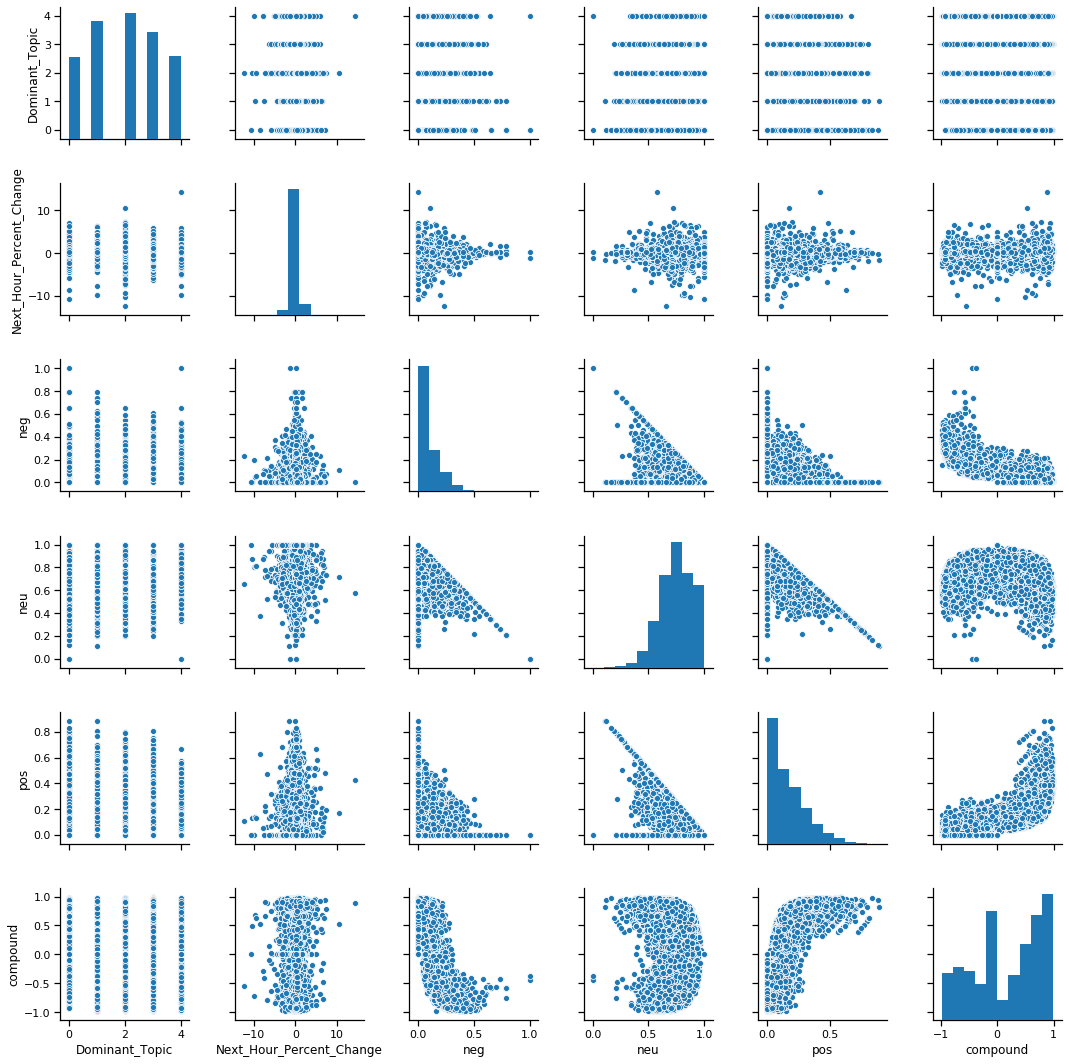

In [37]:
g = sns.pairplot(df_Trump)

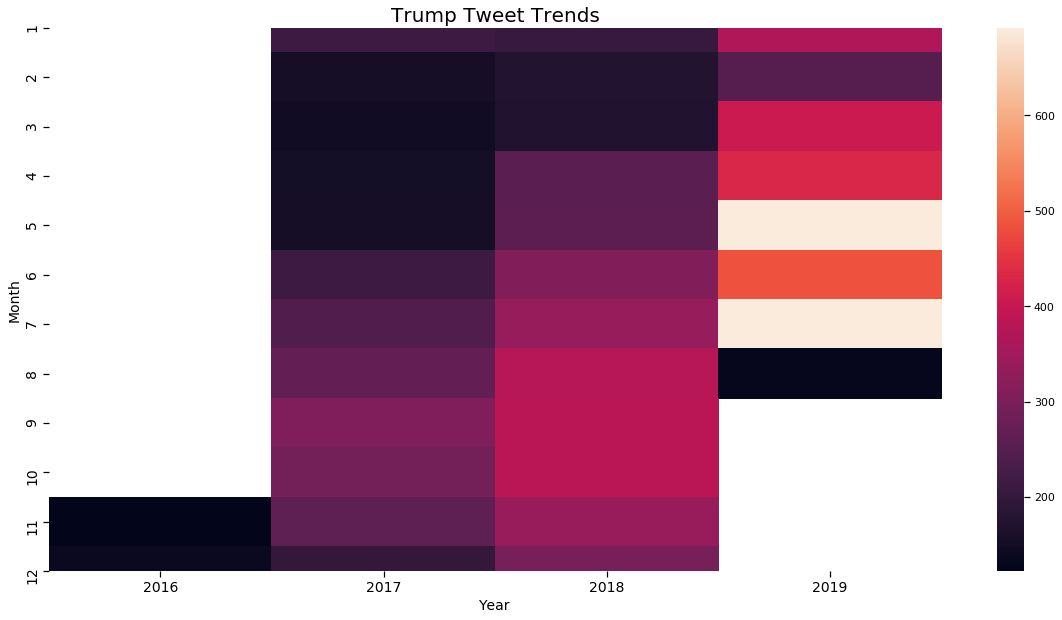

In [38]:
df_tweet_2019 = df_Trump.copy()
df_tweet_2019 = df_tweet_2019.set_index(["datetime"])
df_tweet_2019 = df_tweet_2019.sort_values(by='datetime',ascending=True)
df_tweet_2019['year'] = df_tweet_2019.index.year
df_tweet_2019['month'] = df_tweet_2019.index.month
# df_tweet_2019 = df_tweet_2019[df_tweet_2019.year == 2019]
df_tweet_2019= df_tweet_2019.groupby(['year','month']).size()
df_tweet_2019 = df_tweet_2019.reset_index()
df_tweet_2019 = df_tweet_2019.pivot("month", "year", 0)
df_tweet_2019

fig, ax = plt.subplots(1,1, figsize=(20,10))
ax = sns.heatmap(df_tweet_2019)
ax.set_title('Trump Tweet Trends', fontSize=20)
ax.set_xlabel('Year', fontSize=14)
ax.set_ylabel('Month', fontSize=14)
ax.tick_params(labelsize = 14);

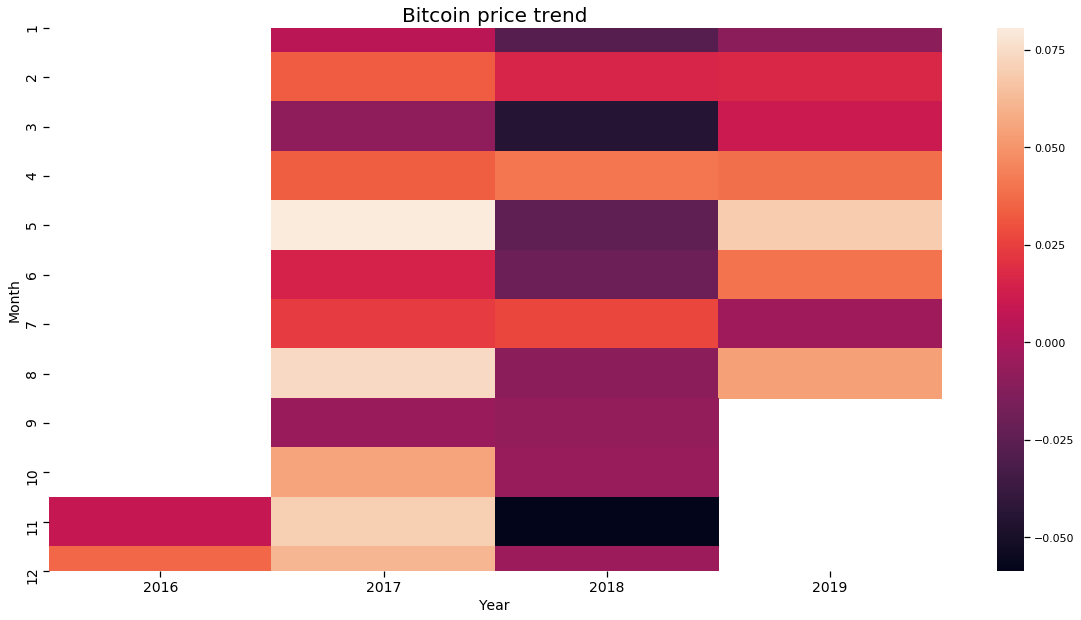

In [39]:
 
df_bitcoin_hm = df_bitcoin.copy()
df_bitcoin_hm['year'] = df_bitcoin_hm.index.year
df_bitcoin_hm['month'] = df_bitcoin_hm.index.month
# df_tweet_2019 = df_tweet_2019[df_tweet_2019.year == 2019]
df_bitcoin_hm= df_bitcoin_hm.groupby(['year','month'])['Next_Hour_Percent_Change'].mean()
df_bitcoin_hm = df_bitcoin_hm.reset_index()
# df_bitcoin_hm = df_bitcoin_hm.drop(columns=['Timestamp'])
df_bitcoin_hm = df_bitcoin_hm.pivot("month", "year", "Next_Hour_Percent_Change")
df_bitcoin_hm

fig, ax = plt.subplots(1,1, figsize=(20,10))
ax = sns.heatmap(df_bitcoin_hm)
ax.set_title('Bitcoin price trend', fontSize=20)
ax.set_xlabel('Year', fontSize=14)
ax.set_ylabel('Month', fontSize=14)
ax.tick_params(labelsize = 14);

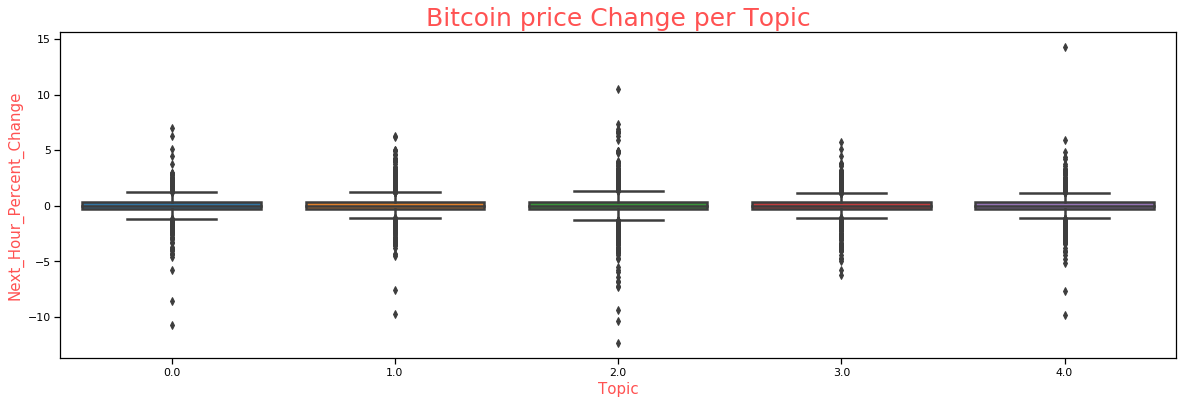

In [40]:
# Box plot to show which topic of trumpA tweet has more effect on bitcoin price change
fig, ax = plt.subplots(figsize=(20,6)) 
ax = sns.boxplot(x="Dominant_Topic", y="Next_Hour_Percent_Change", data=df_Trump)
ax.set_ylabel(None);
ax.set_xlabel('Topic', fontsize=15, color = "#FF5252")
ax.set_ylabel('Next_Hour_Percent_Change', fontsize=15, color = "#FF5252")
ax.set_title('Bitcoin price Change per Topic', fontsize=25, color = "#FF5252")
plt.savefig('Boxplot.png', bbox_inches='tight')
plt.show()

In [41]:
df_model = df_Trump.copy()
df_model = df_model.drop(columns=['text','datetime','neg','neu','pos'])
df_model['Dominant_Topic'] = df_model['Dominant_Topic'].astype('int')
df_model =df_model[df_model['Dominant_Topic'].isin([1,2,3])]


df_model['Next_Hour_Percent_Change'] = (df_model['Next_Hour_Percent_Change']>0)*1
# df_model['Sentiment'] = (df_model['compound']>0)*1

df_model = pd.get_dummies(df_model,columns=['Dominant_Topic'],drop_first=True)
df_model.rename(columns={'compound': 'Sentiment','Dominant_Topic_1':'Tweets_Topic_1','Dominant_Topic_2':'Tweets_Topic_2','Dominant_Topic_3':'Tweets_Topic_3','Dominant_Topic_4':'Tweets_Topic_4'}, inplace = True)

df_model
# split data into train and test 
X_train, X_test, y_train, y_test =train_test_split(df_model.loc[:,df_model.columns != 'Next_Hour_Percent_Change'],
                                                 df_model.Next_Hour_Percent_Change,
                                                 test_size=0.20,
                                                 random_state=42)


<B>Modeling</B>

<B> I.  Logistic Regression (including Ridge and Lasso) </B>

In [42]:
score=[]

In [43]:
# Logistic Model
model_logistic_regr = LogisticRegression(C=100000, solver = "lbfgs", max_iter=10000, random_state=43)
model_logistic_regr.fit(X_train , y_train)

# predictions
y_train_pred_logistic = model_logistic_regr.predict(X_train) 
y_test_pred_logistic = model_logistic_regr.predict(X_test)

# accuracy
train_score_logistic = accuracy_score(y_train, y_train_pred_logistic)
test_score_logistic = accuracy_score(y_test, y_test_pred_logistic)

score.append(['logistic',train_score_logistic,test_score_logistic])

print('Training set accuracy for multiple logistic regression = ', train_score_logistic)
print('Test set accuracy for multiple logistic regression = ', test_score_logistic)

Training set accuracy for multiple logistic regression =  0.5279654654654654
Test set accuracy for multiple logistic regression =  0.5165165165165165


In [44]:
# Logistic Model with Lasso
model_logit_regr_lasso = LogisticRegressionCV(solver='liblinear', penalty='l1', cv=5, random_state=43)
model_logit_regr_lasso.fit(X_train, y_train)

# predictions
y_train_pred_logit_lasso = model_logit_regr_lasso.predict(X_train) 
y_test_pred_logit_lasso = model_logit_regr_lasso.predict(X_test)

# accuracy
train_score_logit_lasso = accuracy_score(y_train, y_train_pred_logit_lasso)
test_score_logit_lasso = accuracy_score(y_test, y_test_pred_logit_lasso)

score.append(['logistic with lasso',train_score_logit_lasso,test_score_logit_lasso])



print('Training set accuracy for Lasso multiple logistic regression = ', train_score_logit_lasso)
print('Test set accuracy for Lasso multiple logistic regression = ', test_score_logit_lasso)

Training set accuracy for Lasso multiple logistic regression =  0.5279654654654654
Test set accuracy for Lasso multiple logistic regression =  0.5165165165165165


In [45]:
# Logistic Model with Ridge
model_logit_regr_ridge = LogisticRegressionCV(solver='liblinear', penalty='l2', cv=5, random_state=43)
model_logit_regr_ridge.fit(X_train, y_train)

# predictions
y_train_pred_logit_ridge = model_logit_regr_ridge.predict(X_train) 
y_test_pred_logit_ridge = model_logit_regr_ridge.predict(X_test)

# accuracy
train_score_logit_ridge = accuracy_score(y_train, y_train_pred_logit_ridge)
test_score_logit_ridge = accuracy_score(y_test, y_test_pred_logit_ridge)

score.append(['logistic with ridge',train_score_logit_ridge,test_score_logit_ridge])



print('Training set accuracy for Ridge multiple logistic regression = ', train_score_logit_ridge)
print('Test set accuracy for Ridge multiple logistic regression = ', test_score_logit_ridge)

Training set accuracy for Ridge multiple logistic regression =  0.5279654654654654
Test set accuracy for Ridge multiple logistic regression =  0.5165165165165165


<B> II.  k-NN </B>

In [46]:
np.random.seed(42)

knn_scores = []
ks = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,25, 50]

for k in ks:
    knn = KNeighborsClassifier(k)
    knn_scores.append(np.mean(cross_val_score(knn, X_train, y_train, cv=5)))

# pd.DataFrame(knn_scores,ks)

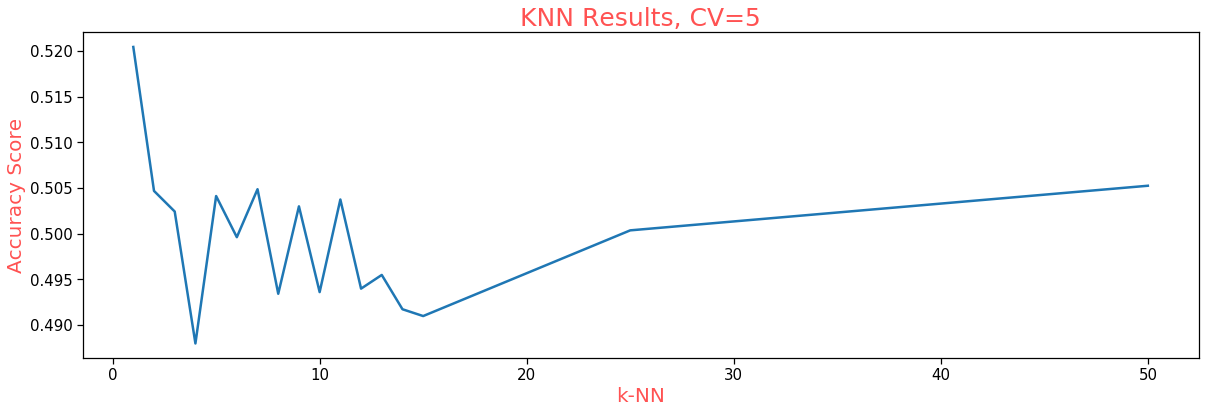

In [47]:
#ax.plot(knn_scores, ks, '-',  label='Predicted')
fig, ax = plt.subplots(figsize=(20,6)) 
ax = sns.lineplot(ks, knn_scores)
#ax.set(xlabel='k-NN', ylabel='Accuracy Score', title='KNN Results, CV=5')

ax.tick_params(labelsize = 15);
ax.set_xlabel("k-NN", fontsize=20, color = "#FF5252");
ax.set_ylabel("Accuracy Score", fontsize=20, color = "#FF5252");
ax.set_title("KNN Results, CV=5", fontsize=25, color = "#FF5252")
plt.savefig('KNNResultsCV5.png', bbox_inches='tight');
plt.show()

In [48]:
# Select k=3 as the best result from class validation above

np.random.seed(43)
knn3 = KNeighborsClassifier(3)
knn3.fit(X_train,y_train)

# predictions
y_train_pred_knn = knn3.predict(X_train) 
y_test_pred_knn = knn3.predict(X_test)

# accuracy
train_score_knn = accuracy_score(y_train, y_train_pred_knn)
test_score_knn = accuracy_score(y_test, y_test_pred_knn)
score.append(['knn',train_score_knn,test_score_knn])

print('Training set accuracy for knn(3)', train_score_knn)
print('Test set accuracy for knn(3)', test_score_knn)

Training set accuracy for knn(3) 0.6871246246246246
Test set accuracy for knn(3) 0.5015015015015015


In [49]:
print('Confusion matrix for k-NN = 7')
print(metrics.confusion_matrix(y_test, y_test_pred_knn)) 

Confusion matrix for k-NN = 7
[[297 347]
 [317 371]]


<B> III.  Tree </B>

<B> (a).  Simple Descision Tree </B>

In [50]:
def getDescisionTreeModel(depth):
    """
    Create a simple decision tree with selected depth.
    depth: max depth for tree creation
    
    return : tree model
    """
    return DecisionTreeClassifier(
                                criterion='gini',
                                splitter='best',
                                max_depth=depth,
                                min_samples_split=2,
                                min_samples_leaf=1,
                                min_weight_fraction_leaf=0.0,
                                max_features=None,
                                random_state=None,
                                max_leaf_nodes=None,
                                min_impurity_decrease=0.0,
                                min_impurity_split=None,
                                class_weight=None,
                                presort=False)

def calc_meanstd(X_train, y_train, depths):
    cvmeans = []
    train_scores = []
    cvstds=[]

    for depth in depths:
        model= getDescisionTreeModel(depth)

        score = cross_val_score(estimator = model,
                          X=X_train,
                          y=y_train,
                          groups=None,
                          scoring=None,
                          cv=5,
                          n_jobs=-1,
                          verbose=0,
                          fit_params=None,
                          pre_dispatch='2*n_jobs')
        model.fit(X_train,y_train)
        train_scores.append(accuracy_score(y_train,model.predict(X_train)))
        cvmeans.append(score.mean())
        cvstds.append(score.std())
            
    return np.array(cvmeans), np.array(cvstds), np.array(train_scores)

In [51]:
depths = list(range(1, 30, 1))
cvmeans, cvstds, train_scores = calc_meanstd(X_train, y_train, depths)

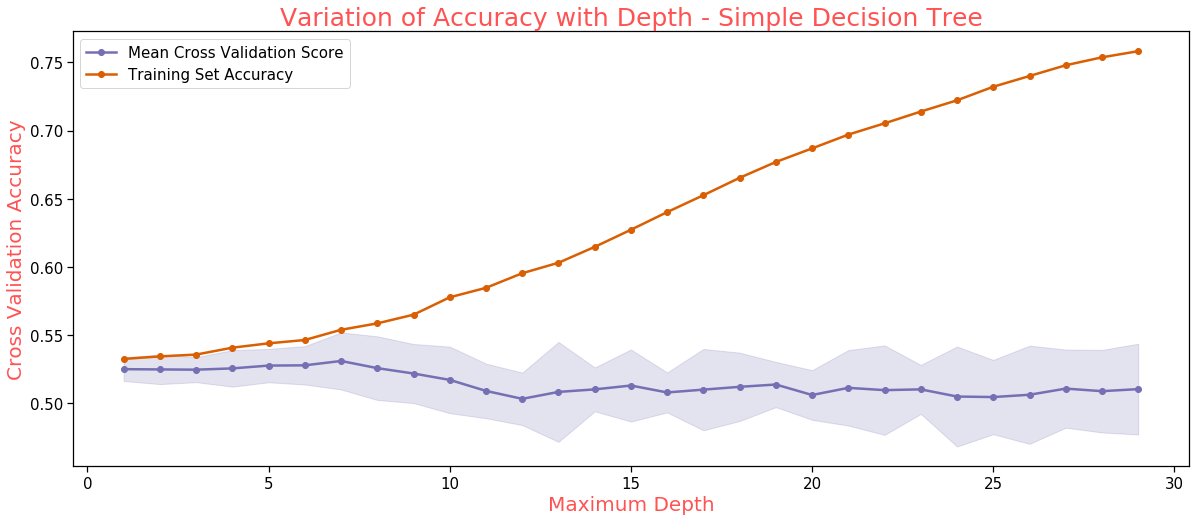

In [52]:
def plot_accuracy_depth(ax):
    ax.fill_between(depths, cvmeans + 2*cvstds, cvmeans -  2*cvstds, alpha=0.2, color= "#7570b3")
    ax.set_ylabel("Cross Validation Accuracy", fontsize=20, color = "#FF5252")
    ax.set_xlabel("Maximum Depth", fontsize=20, color = "#FF5252")
    ax.set_title('Variation of Accuracy with Depth - Simple Decision Tree', fontsize=25, color = "#FF5252")
    ax.plot(depths, cvmeans, 'b-', marker='o', color= "#7570b3", label="Mean Cross Validation Score")
    ax.plot(depths,train_scores,'b-',marker='o', color="#d95f02", label="Training Set Accuracy")
    ax.tick_params(labelsize=15)
    ax.legend(fontsize=15)
    
fig, ax = plt.subplots(figsize=(20,8))
plot_accuracy_depth(ax)
plt.savefig('SimpleDesisionTree.png', bbox_inches='tight');
plt.show()

In [53]:
trees = pd.DataFrame({'Max Depth':depths, 
                      'CV Accuracy Score Mean':cvmeans})
best_depth = int(trees.loc[trees["CV Accuracy Score Mean"].idxmax()]['Max Depth'])
print("The best depth was found to be:", best_depth)

The best depth was found to be: 7


In [54]:
#Evalaute the performance at the best depth
model_tree = DecisionTreeClassifier(max_depth=best_depth)
model_tree.fit(X_train, y_train)


#Check Accuracy of Spam Detection in Train and Test Set
acc_trees_training = accuracy_score(y_train, model_tree.predict(X_train))
acc_trees_testing  = accuracy_score(y_test,  model_tree.predict(X_test))

score.append(['Simple Descision Tree',acc_trees_training,acc_trees_testing])


print("Simple Decision Trees: Accuracy, Training Set \t : {:.2%}".format(acc_trees_training))
print("Simple Decision Trees: Accuracy, Testing Set \t : {:.2%}".format(acc_trees_testing))

Simple Decision Trees: Accuracy, Training Set 	 : 55.39%
Simple Decision Trees: Accuracy, Testing Set 	 : 51.88%


In [55]:
from sklearn import tree
import pydot

file_name = "data/decision_tree.dot"
tree.export_graphviz(model_tree, out_file = file_name) 


(graph,) = pydot.graph_from_dot_file(file_name)
graph.write_png('data/image_tree.png')

![title](data/image_tree.png)

<B> (b).  Bagging </B>

In [56]:
# Bagging Tree Model

def prepare_struct_df(n, idx_name):
    index = list(map(lambda i : "{0} row {1}".format(idx_name, i+1), range(n)))
    df = pd.DataFrame(index= index)
    return df
    
def build_model(tree_depth):
    X_train_temp = df_model.sample(frac=1, replace=True)
    y_train_temp = X_train_temp['Next_Hour_Percent_Change'].values
    X_train_temp = X_train_temp.iloc[:, X_train_temp.columns != 'Next_Hour_Percent_Change'].values    

    model = getDescisionTreeModel(tree_depth)
    
    model.fit(X_train_temp, y_train_temp)  
    return model.predict(X_train), model.predict(X_test), model
    
def bagger(n_trees: int, tree_depth: int,  random_seed=0) -> (pd.DataFrame, pd.DataFrame, list):
    """A function that takes as 
    
    Inputs:
      n_tres
      tree_depth 
      a random_seed (default =0)
    
    Returns:
      bagging_train dataframe (as described above)
      bagging_test dataframe (as described above)
      bagging_models every trained model for each bootstrap (you will need this in Q3.2)
    """
    bagging_train_df = prepare_struct_df(len(X_train), "Training")
    bagging_test_df = prepare_struct_df(len(X_test), "Test")
    bagging_models = []
    np.random.seed(random_seed)
    for i in range(n_trees):
        bagging_train_predict, bagging_test_predict, model = build_model(tree_depth)
        new_col = "Bootstrap Model {0}'s prediction".format(i+1)
        bagging_train_df[new_col] = bagging_train_predict
        bagging_test_df[new_col] = bagging_test_predict
        bagging_models.append(model)
        
    return bagging_train_df, bagging_test_df, bagging_models

In [57]:
n_trees = 55 
tree_depth = 20
bagging_train_df, bagging_test_df, bagging_models = bagger(n_trees, tree_depth,  random_seed= 0)

In [58]:
def getCombinedPrediction(X):
    return 1 * (np.mean(X, axis=1) > .5)


bagging_accuracy_train = accuracy_score(y_train, getCombinedPrediction(bagging_train_df))
bagging_accuracy_test = accuracy_score(y_test, getCombinedPrediction(bagging_test_df))
score.append(['Bagging',bagging_accuracy_train,bagging_accuracy_test])


print('Accuracy Score for Bagging Training Set \t : {:0.2%}'.format(bagging_accuracy_train ))
print('Accuracy Score for Bagging Testing Set  \t : {:0.2%}'.format(bagging_accuracy_test))

Accuracy Score for Bagging Training Set 	 : 69.39%
Accuracy Score for Bagging Testing Set  	 : 67.87%


In [59]:
def running_predictions(prediction_dataset: np.ndarray, targets: np.ndarray) -> np.ndarray:
    """A function to predict examples' class via the majority among trees (ties are predicted as 0)
    
    Inputs:
      prediction_dataset - a (n_examples by n_sub_models) dataset (not a dataframe), where each entry [i,j] is sub-model j's prediction
          for example i
      targets - the true class labels
    
    Returns:
      a vector where vec[i] is the model's accuracy when using just the first i+1 sub-models
    """
    
    n_trees = prediction_dataset.shape[1]
    
    # find the running percentage of models voting 1 as more models are considered
    running_percent_1s = np.cumsum(prediction_dataset, axis=1)/np.arange(1,n_trees+1)
    
    # predict 1 when the running average is above 0.5
    running_conclusions = running_percent_1s > 0.5
    
    # check whether the running predictions match the targets
    running_correctnesss = running_conclusions == targets.reshape(-1,1)
    
    return np.mean(running_correctnesss, axis=0)
    # returns a 1-d series of the accuracy of using the first n trees to predict the targets
    
    

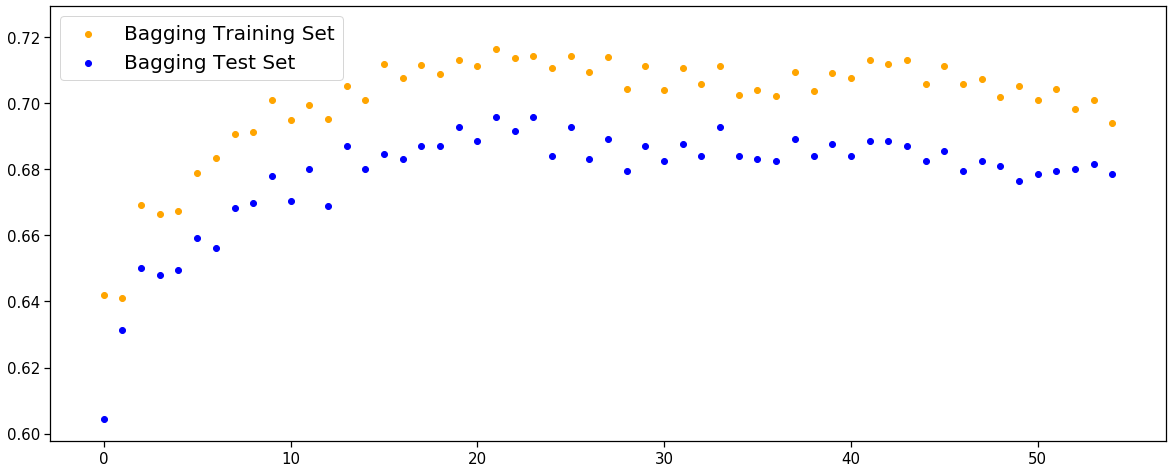

In [60]:
# plotting code for bagging
bagging_train_pred = running_predictions(bagging_train_df.values, y_train.values)
bagging_test_pred  = running_predictions(bagging_test_df.values, y_test.values)

fig, ax = plt.subplots(figsize=(20, 8))
ax.scatter(np.arange(0,55), bagging_train_pred, color='orange', marker="o", label="Bagging Training Set")
ax.scatter(np.arange(0,55), bagging_test_pred, color='blue', marker="o", label="Bagging Test Set")
ax.legend(fontsize=20)
ax.tick_params(labelsize=15)
fig.savefig('Bagging.png', bbox_inches='tight');
plt.show()

<B> (c).  Random Forest Tree </B>

In [61]:
# Based on Random Tree Forest
from sklearn.ensemble import RandomForestClassifier

#Training
random_model = RandomForestClassifier(n_estimators=int(1), max_depth=best_depth)
random_model.fit(X_train, y_train)

#Predict
y_pred_train = random_model.predict(X_train)
y_pred_test = random_model.predict(X_test)

#Perfromance Evaluation
acc_random_forest_training = accuracy_score(y_train, y_pred_train)
acc_random_forest_testing = accuracy_score(y_test, y_pred_test)
score.append(['Random Forest',acc_random_forest_training,acc_random_forest_testing])

print("Random Forest: Accuracy, Training Set : {:0.2f}%".format(acc_random_forest_training))
print("Random Forest: Accuracy, Testing Set :  {:0.2f}%".format(acc_random_forest_testing))

Random Forest: Accuracy, Training Set : 0.55%
Random Forest: Accuracy, Testing Set :  0.53%


In [62]:
def extract_top_predictors(model_list):
    return pd.Series(list(map(lambda m : X_train.columns[m.tree_.feature[0]], 
                                       model_list)))
 

In [63]:
# Find top predictors for Bagging and Random Models
top_predictors_rf = extract_top_predictors(random_model.estimators_)
print("*************Random Forest Predictors*************")
print(top_predictors_rf.value_counts() ,end="\n\n")

top_predictors_bagging = extract_top_predictors(bagging_models)
print("*************Bagging Pred*************")
print(top_predictors_bagging.value_counts())

*************Random Forest Predictors*************
Sentiment    1
dtype: int64

*************Bagging Pred*************
Sentiment         52
Tweets_Topic_2     3
dtype: int64


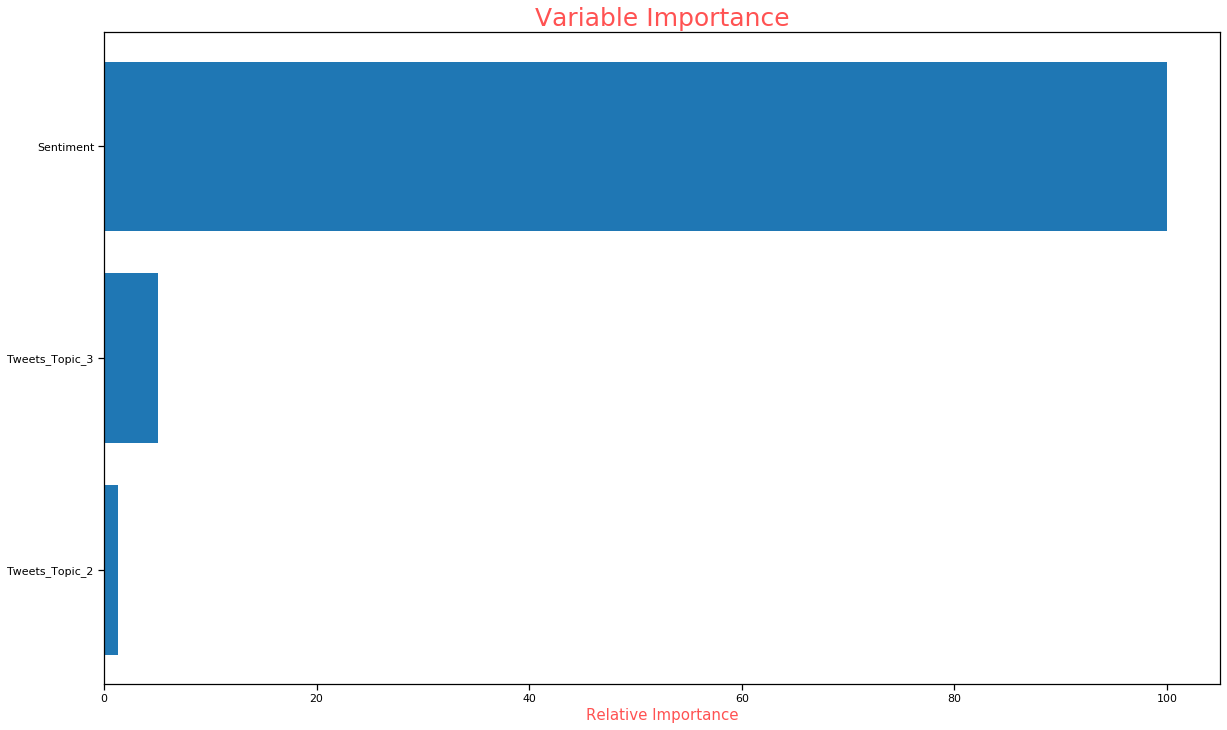

In [64]:
#Top Features
feature_importance = random_model.feature_importances_
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5

#Plot
plt.figure(figsize=(20,12))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X_train.columns[sorted_idx])
plt.xlabel('Relative Importance', fontsize=15, color = "#FF5252")
plt.title('Variable Importance', fontsize=25, color = "#FF5252")
plt.savefig('TopPredictors.png', bbox_inches='tight');
plt.show()

<B> (d).  AdaBoost </B>

In [65]:
# Adaboost model
from sklearn.ensemble import AdaBoostClassifier

#Training
model = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=2), 
                           n_estimators=800, 
                           learning_rate=0.05)
model.fit(X_train, y_train)

#Predict
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

#Performance Evaluation
acc_boosting_training = accuracy_score(y_train, y_pred_train)
acc_boosting_test = accuracy_score(y_test, y_pred_test)
score.append(['Ada Boost',acc_boosting_training,acc_boosting_test])


print("Ada Boost:\tAccuracy, Training Set \t: {:0.2f}%".format(acc_boosting_training))
print("Ada Boost:\tAccuracy, Testing Set \t: {:0.2f}%".format(acc_boosting_test))

Ada Boost:	Accuracy, Training Set 	: 0.63%
Ada Boost:	Accuracy, Testing Set 	: 0.50%


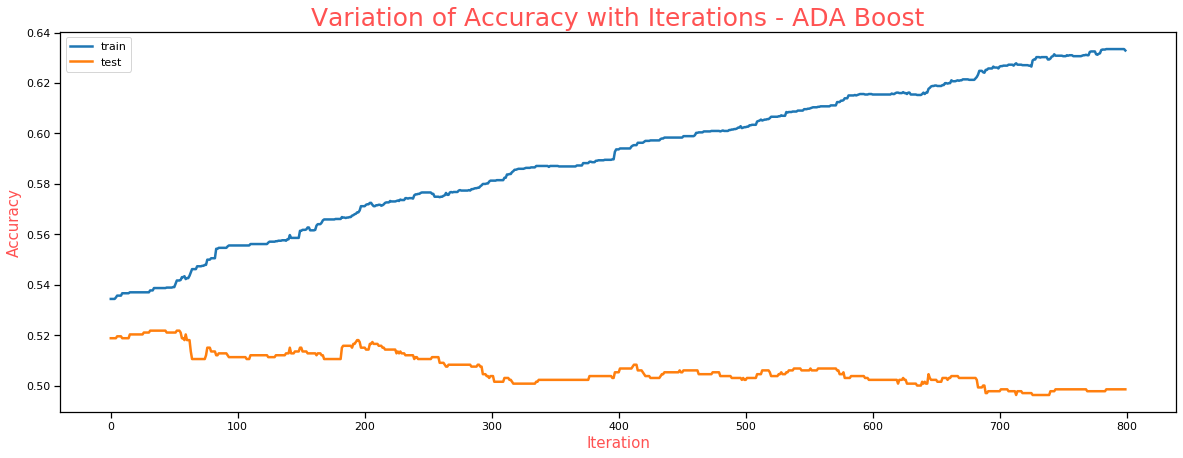

In [66]:
#Plot Iteration based score
train_scores = list(model.staged_score(X_train,y_train))
test_scores = list(model.staged_score(X_test, y_test))

plt.figure(figsize=(20,7))
plt.plot(train_scores,label='train')
plt.plot(test_scores,label='test')
plt.xlabel('Iteration', fontsize=15, color = "#FF5252")
plt.ylabel('Accuracy', fontsize=15, color = "#FF5252")
plt.title("Variation of Accuracy with Iterations - ADA Boost", fontsize=25, color = "#FF5252")
plt.savefig('ADABoost.png', bbox_inches='tight');
plt.legend();

<B> IV.  Neural Network </B>

In [67]:
X_train = X_train.values.reshape(X_train.shape[0], X_train.shape[1])
X_test = X_test.values.reshape(X_test.shape[0], X_test.shape[1])
y_train = y_train.values.reshape(-1,1)
y_test = y_test.values.reshape(-1,1)

In [68]:
# Neural Network
n_neurons = 50
kernel_weight = 0.003
bias_weight = 0.003


model_neural_net = models.Sequential(name='tweets_nn')
# first hidden layer 
model_neural_net.add(layers.Dense(n_neurons, activation='relu', input_shape=(3,)))
model_neural_net.add(layers.Dropout(0.3))
model_neural_net.add(layers.Dense(n_neurons, activation='relu'))
model_neural_net.add(layers.Dropout(0.3))
model_neural_net.add(layers.Dense(n_neurons, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(kernel_weight), 
                                    bias_regularizer=tf.keras.regularizers.l2(bias_weight) ))
model_neural_net.add(layers.Dropout(0.3))
# output layer, one neuron 
model_neural_net.add(layers.Dense(1,  activation='sigmoid'))
# model_t.summary()

In [69]:
loss_fn = losses.BinaryCrossentropy()
model_neural_net.compile(loss=loss_fn, optimizer='adam',metrics=['accuracy']) 
history = model_neural_net.fit(X_train, y_train, validation_split=0.33,epochs=500, batch_size=116, verbose=0)

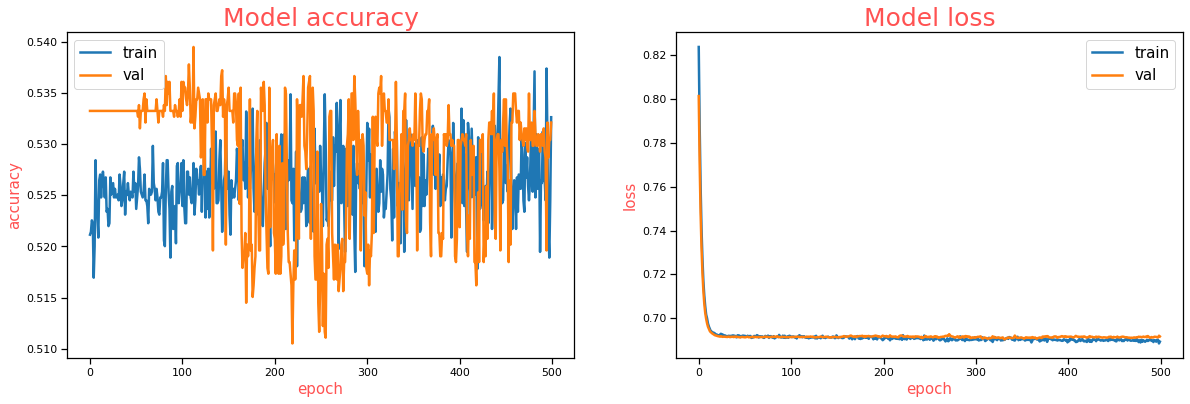

In [70]:
# plot accuracy and loss for the test set
fig, ax = plt.subplots(1,2, figsize=(20,6))

ax[0].plot(history.history['accuracy'])
ax[0].plot(history.history['val_accuracy'])
ax[0].set_title('Model accuracy', fontsize=25, color = "#FF5252")
ax[0].set_ylabel('accuracy', fontsize=15, color = "#FF5252")
ax[0].set_xlabel('epoch', fontsize=15, color = "#FF5252")
ax[0].legend(['train', 'val'], loc='best', fontsize=15)

ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_title('Model loss', fontsize=25, color = "#FF5252")
ax[1].set_ylabel('loss', fontsize=15, color = "#FF5252")
ax[1].set_xlabel('epoch', fontsize=15, color = "#FF5252")
ax[1].legend(['train', 'val'], loc='best', fontsize=15)
fig.savefig('ModelAccuracyLoss.png', bbox_inches='tight');
plt.show()

In [71]:
test_loss, test_accuracy = model_neural_net.evaluate(X_test, y_test, verbose=0)
print(f'Test accuracy={test_accuracy:.4f}') 
training_accuracy = np.mean(history.history['accuracy'])
score.append(['Neural Network',training_accuracy,test_accuracy])

Test accuracy=0.5120


In [72]:
model_df = pd.DataFrame(score,columns=['Model','Training_Accuracy','Testing_Accuracy'])

html = model_df.sort_values('Training_Accuracy', ascending=False).to_html()

#write html to file
text_file = open("model_results.html", "w")
text_file.write(html)
text_file.close()
model_df.sort_values('Training_Accuracy', ascending=False)

,Model,Training_Accuracy,Testing_Accuracy
5,Bagging,0.693881,0.678679
3,knn,0.687125,0.501502
7,Ada Boost,0.632883,0.498498
4,Simple Descision Tree,0.553866,0.518769
6,Random Forest,0.546171,0.530781
0,logistic,0.527965,0.516517
1,logistic with lasso,0.527965,0.516517
2,logistic with ridge,0.527965,0.516517
8,Neural Network,0.526300,0.512012
